# Part II: Transform Imaging Data into OMOP CDM

### Prerequisites
* Download ODBC Driver 18 from web <https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/install-microsoft-odbc-driver-sql-server-macos?view=sql-server-ver16>
* OMOP CDM instance with the connection string and authentication information. If your database access limits IP addresses, make sure to add your IP address before running the connection strings.
* Install SQL processing package, i.e., pyodbc.
* Files or database that non-image data is stored: demographic, clinical assessments, labs, visits, etc.
* Locate your imaging files: local paths, cloud storage services (e.g., Microsoft Azure)

In [1]:
import requests
import pandas as pd
import pydicom
from pathlib import Path
from urllib3.filepost import encode_multipart_formdata, choose_boundary
from azure.identity import DefaultAzureCredential

/Users/wooyeonpark/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
!pip install azure-cli

In [67]:
!az login

Python(88790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/wooyeonpark/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
A web browser has been opened at https://login.microsoftonline.com/organizations/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.
The following tenants don't contain accessible subscriptions. Use 'az login --allow-no-subscriptions' to have tenant level access.
a30f0094-9120-4aab-ba4c-e5509023b2d5 'OHDSI'
b19c134a-14c9-4d4c-af65-c420f94c8cbb 'Texas State University'
e38fdd56-dd64-4d67-b048-e7c0ae321d11 'Gates Ventures'
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "9fa4f438-b1e6-473b-803f-86f8aedf0dec",
    "id": "f2ae80c4-c742-44c2-a730-eddf9371b0fa",
    "isDe

In [68]:
# Run the az command and capture its output
captured_output = !az account get-access-token --resource https://dicom.healthcareapis.azure.com --query accessToken --output tsv

# The output is a special IPython.utils.text.SList object which behaves like a list.
# If the command outputs a single line (like an access token), it will be the first element.
bearer_token = captured_output[2].strip()

Python(88837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [69]:
# check connection
base_dicomweb_url = 'https://imgextpoc-adnidicom.dicom.azurehealthcareapis.com/v2'

headers = {
    'Accept': "application/json",
    'Authorization': 'Bearer ' + bearer_token
    }
dicomweb_study_query_url =  base_dicomweb_url + '/studies/'
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers)
response

<Response [200]>

In [72]:
# Extract all metadata from DICOM server
# To avoid repetitive information, we filter extracting one instance metadata per series
import requests
import pandas as pd

# Function to fetch metadata for the first instance in a given series
def fetch_series_metadata(base_url, study_uid, series_uid, headers):
    # Endpoint to fetch instances within the series
    instances_url = f"{base_url}/studies/{study_uid}/series/{series_uid}/instances"
    instances_response = requests.get(instances_url, headers=headers)
    if instances_response.status_code != 200:
        print(f"Error fetching instances for series {series_uid}: {instances_response.status_code}")
        return {}

    instances = instances_response.json()
    if not instances:
        print(f"No instances found for series {series_uid}")
        return {}

    # Fetch metadata for the first instance
    instance_uid = instances[0]['00080018']['Value'][0]
    instance_metadata_url = f"{base_url}/studies/{study_uid}/series/{series_uid}/instances/{instance_uid}/metadata"
    instance_metadata_response = requests.get(instance_metadata_url, headers=headers)
    if instance_metadata_response.status_code == 200:
        return instance_metadata_response.json()
    else:
        print(f"Error fetching metadata for instance {instance_uid}: {instance_metadata_response.status_code}")
        return {}

# Function to extract all metadata
def extract_all_metadata(base_url, headers):
    all_metadata = []
    limit = 200
    offset = 0

    while True:
        # Fetch the list of studies with pagination
        studies_url = f"{base_url}/studies"
        studies_response = requests.get(studies_url, params={"limit": limit, "offset": offset}, headers=headers)
        if studies_response.status_code == 204:
            break
        if studies_response.status_code != 200:
            print(f"Error fetching studies: {studies_response.status_code}")
            break
        studies = studies_response.json()

        # Loop through each study and fetch series within it
        for study in studies:
            study_uid = study['0020000D']['Value'][0]

            # Endpoint for fetching series within a study; adjust as needed
            series_url = f"{base_url}/studies/{study_uid}/series"
            
            # Fetch the list of series in the current study
            series_response = requests.get(series_url, headers=headers)
            if series_response.status_code == 200:
                series_list = series_response.json()

                # Extract metadata for each series and add to the list
                for series in series_list:
                    series_uid = series['0020000E']['Value'][0]  # Adjust based on actual response format
                    series_metadata = fetch_series_metadata(base_url, study_uid, series_uid, headers)
                    if series_metadata:
                        metadata_record = {"StudyUID": study_uid, "SeriesUID": series_uid, "Metadata": series_metadata}
                        all_metadata.append(metadata_record)

        # Update offset for next batch of studies
        offset += limit

    # Convert the list of records to a DataFrame
    return pd.DataFrame(all_metadata)

In [73]:
headers = {
    'Authorization': 'Bearer ' + bearer_token,
    'Accept': 'application/dicom+json'
}
base_dicomweb_url = 'https://imgextpoc-adnidicom.dicom.azurehealthcareapis.com/v2'

metadata_df = extract_all_metadata(base_dicomweb_url, headers)
metadata_df.shape

(4756, 3)

In [74]:
metadata_df['Metadata'].iloc[0]

[{'00080005': {'vr': 'CS', 'Value': ['ISO_IR 100']},
  '00080008': {'vr': 'CS',
   'Value': ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS3D', 'DIS2D']},
  '00080013': {'vr': 'TM', 'Value': ['132059.900000']},
  '00080016': {'vr': 'UI', 'Value': ['1.2.840.10008.5.1.4.1.1.4']},
  '00080018': {'vr': 'UI',
   'Value': ['2.16.124.113543.6006.99.02372564384492529391']},
  '00080020': {'vr': 'DA', 'Value': ['20171204']},
  '00080021': {'vr': 'DA', 'Value': ['20171204']},
  '00080022': {'vr': 'DA', 'Value': ['20171204']},
  '00080023': {'vr': 'DA', 'Value': ['20171204']},
  '00080030': {'vr': 'TM', 'Value': ['131221.208000']},
  '00080031': {'vr': 'TM', 'Value': ['132059.809000']},
  '00080032': {'vr': 'TM', 'Value': ['131544.167500']},
  '00080033': {'vr': 'TM', 'Value': ['132059.900000']},
  '00080060': {'vr': 'CS', 'Value': ['MR']},
  '00080070': {'vr': 'LO', 'Value': ['SIEMENS']},
  '00080080': {'vr': 'LO', 'Value': ['UK_MRISC']},
  '00080090': {'vr': 'PN'},
  '00081030': {'vr': 'LO',
   'Valu

In [119]:
# metadata_df.to_pickle('./files/all_metadata.pkl')
# metadata_df = pd.read_pickle('./files/all_metadata.pkl')

In [120]:
metadata_df.head()

,StudyUID,SeriesUID,Metadata
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,"[{'00080005': {'vr': 'CS', 'Value': ['ISO_IR 1..."
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,"[{'00080005': {'vr': 'CS', 'Value': ['ISO_IR 1..."
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,"[{'00080005': {'vr': 'CS', 'Value': ['ISO_IR 1..."
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,"[{'00080005': {'vr': 'CS', 'Value': ['ISO_IR 1..."
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,"[{'00080005': {'vr': 'CS', 'Value': ['ISO_IR 1..."


In [8]:
metadata_df.shape

(4756, 3)

In [9]:
# Function to flatten the nested dictionary of metadata
def flatten_metadata(row):
    flat_metadata = []
    for metadata_dict in row['Metadata']:
        for tag, attributes in metadata_dict.items():
            value = attributes.get('Value', None)
            if isinstance(value, list):
                value = ', '.join(str(v) for v in value)
            flat_metadata.append({
                'StudyUID': row['StudyUID'],
                'SeriesUID': row['SeriesUID'],
                'Tag': tag,
                'vr': attributes.get('vr', None),
                'Value': value
            })
    return flat_metadata

# Flatten the metadata DataFrame
flat_metadata_list = []
for index, row in metadata_df.iterrows():
    flat_metadata_list.extend(flatten_metadata(row))

flat_metadata_df = pd.DataFrame(flat_metadata_list)
flat_metadata_df.shape

(691224, 5)

In [38]:
flat_metadata_df.head()

,StudyUID,SeriesUID,Tag,vr,Value
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,CS,ISO_IR 100
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,CS,"ORIGINAL, PRIMARY, M, NORM, DIS3D, DIS2D"
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080013,TM,132059.900000
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080016,UI,1.2.840.10008.5.1.4.1.1.4
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080018,UI,2.16.124.113543.6006.99.02372564384492529391


In [11]:
# flat_metadata_df.to_pickle('./files/all_metadata_long.pkl')

In [156]:
# import pandas as pd
# flat_metadata_df = pd.read_pickle('./files/all_metadata_long.pkl')

In [7]:
# Load DICOM series that were already uploaded
omop_images = pd.read_pickle('./files/image_series_metadata.pkl')
omop_images.head()

,Study_UID,Series_UID,Attribute Tag,Value,concept_id,concept_name,value_as_number,image_feature_id,measurement_id,measurement_type_concept_id,image_occurrence_date,person_id,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,ISO_IR 100,2128000011,Specific Character Set,NaN,1,1,32817,2017-12-04,2161,1,1147330,4119359
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,ORIGINAL,2128000012,Image Type,NaN,2,2,32817,2017-12-04,2161,1,1147330,4119359
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080013,132059.935000,2128000014,Instance Creation Time,NaN,3,3,32817,2017-12-04,2161,1,1147330,4119359
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080020,20171204,2128000016,Study Date,NaN,4,4,32817,2017-12-04,2161,1,1147330,4119359
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080021,20171204,2128000017,Series Date,NaN,5,5,32817,2017-12-04,2161,1,1147330,4119359


In [14]:
flat_metadata_df[flat_metadata_df.SeriesUID.isin(omop_images.Series_UID)].shape

(130570, 5)

In [24]:
# exclude DICOM series that were already uploaded
series_to_upload = flat_metadata_df[~flat_metadata_df.SeriesUID.isin(omop_images.Series_UID)]

In [16]:
# Load DICOM OMOP vocab
omop_image_concept = pd.read_csv('./files/omop_table_staging.csv')
omop_image_concept.head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,2128000010,Length to End,Measurement,DICOM,DICOM Attributes,NaN,00080001,19930101,20991231,NaN
1,2128000011,Specific Character Set,Measurement,DICOM,DICOM Attributes,NaN,00080005,19930101,20991231,NaN
2,2128000012,Image Type,Measurement,DICOM,DICOM Attributes,NaN,00080008,19930101,20991231,NaN
3,2128000013,Instance Creation Date,Measurement,DICOM,DICOM Attributes,NaN,00080012,19930101,20991231,NaN
4,2128000014,Instance Creation Time,Measurement,DICOM,DICOM Attributes,NaN,00080013,19930101,20991231,NaN


In [19]:
omop_image_concept.shape #(8047, 10)

(8047, 10)

In [28]:
# Select DICOM tags from OMOP Concept file
selected_attributes = omop_image_concept[omop_image_concept['concept_class_id']=="DICOM Attributes"]

In [22]:
len(selected_attributes) #2824

2824

In [31]:
# Add OMOP concept IDs
series_to_upload = series_to_upload.merge(selected_attributes[['concept_id', 'concept_name', 'concept_code']], how = 'inner', left_on = 'Tag', right_on = 'concept_code')

In [181]:
series_to_upload.head()

,StudyUID,SeriesUID,Tag,vr,Value,concept_id,concept_name,concept_code
0,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080005,CS,ISO_IR 100,2128000011,Specific Character Set,00080005
1,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080008,CS,"ORIGINAL, PRIMARY, PERFUSION, NONE, ND, NORM, ...",2128000012,Image Type,00080008
2,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080013,TM,132514.750000,2128000014,Instance Creation Time,00080013
3,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080020,DA,20180314,2128000016,Study Date,00080020
4,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080021,DA,20180314,2128000017,Series Date,00080021


In [33]:
# Top attributes in the dataset
series_to_upload.groupby('concept_name')['Value'].nunique().sort_values(ascending=False)[:20]

concept_name
Content Time                           3788
Series Time                            3778
Acquisition Time                       3590
Instance Creation Time                 3417
Image Position (Patient)               3173
Slice Location                         3052
SAR                                    2583
Window Width                           2497
Imaging Frequency                      2217
Window Center                          1786
Image Orientation (Patient)             476
Study Time                              447
Performed Procedure Step Start Time     417
Study Date                              355
Series Date                             355
Content Date                            355
Acquisition Date                        354
Instance Number                         261
Patient's Weight                        226
Echo Time                               166
Name: Value, dtype: int64

In [37]:
# Check for duplicates
series_to_upload[series_to_upload[['StudyUID', 'SeriesUID', 'concept_code','Value']].duplicated()].shape # no duplicates

(0, 8)

In [185]:
# Subset for segmenatation
subset = series_to_upload[series_to_upload['concept_id'].isin([2128000367, 2128000368, 2128000366])]

In [190]:
subset.head()

,StudyUID,SeriesUID,Tag,vr,Value,concept_id,concept_name,concept_code
23,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00180080,DS,3400,2128000366,Repetition Time,00180080
24,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00180081,DS,13,2128000367,Echo Time,00180081
85,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.08222330924382953005,00180080,DS,581,2128000366,Repetition Time,00180080
86,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.08222330924382953005,00180081,DS,7.38,2128000367,Echo Time,00180081
145,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.1604978762653772785,00180080,DS,4800,2128000366,Repetition Time,00180080


In [188]:
# Pivot the DataFrame
df_wide = subset.pivot_table(
    index=['StudyUID', 'SeriesUID'],
    columns='concept_id',
    values='Value',
    aggfunc='first'
).reset_index()

# Flatten the columns
df_wide.columns.name = None
df_wide.columns = [str(col) for col in df_wide.columns]

df_wide.head()

,StudyUID,SeriesUID,2128000366,2128000367,2128000368
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,571,4.92,NaN
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,650,20,NaN
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,571,7.38,NaN
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,8020,50,NaN
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,20,5,NaN


In [192]:
df_wide['2128000366'] = df_wide['2128000366'].astype(float)
df_wide['2128000367'] = df_wide['2128000367'].astype(float)
df_wide['2128000368'] = df_wide['2128000368'].astype(float)

In [194]:
df_wide_subset = df_wide[(((df_wide['2128000368']>=800) & (df_wide['2128000368'] <=1100)) |(df_wide['2128000368']<500)) & 
(df_wide['2128000367'] < 10) & (((df_wide['2128000366'] >= 1500) & (df_wide['2128000366'] <= 2500)) | (df_wide['2128000366'] <10))]

In [195]:
df_wide_subset.to_csv('./files/rest_of_series_07252024.csv')

#### Gather DICOM attributes for Image Extension tables

In [157]:
# PTID 00100020
# StudyDate (00080020) v
# Acquisition Date (00080022) v
# Study Description (00081030) 
# Series Description (0008103E) 
# Modality (00080060)
# Body Part Examined (00180015)
# SOP Class UID (00080016) v
df_subset = flat_metadata_df[flat_metadata_df['Tag'].isin(['00100020', '00080020', '00080022', '00081030', '0008103E', '00080060', '00180015', '00080016'])]
df_subset = df_subset.pivot(index=['StudyUID', 'SeriesUID'], columns='Tag', values='Value').reset_index()
df_subset.columns.name = None
df_subset.head()

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Axial T2 STAR,003_S_6260,BRAIN
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,HighResHippocampus,003_S_6260,BRAIN
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,3 Plane Localizer,003_S_6260,BRAIN


In [158]:
df_subset.shape

(4756, 10)

In [49]:
df_id = pd.read_csv('./files/registry_idmap.csv')
df_id

,source_id,person_id,source_name
0,011_S_0002,1,ADNI
1,022_S_0001,2,ADNI
2,011_S_0003,3,ADNI
3,022_S_0004,4,ADNI
4,011_S_0005,5,ADNI
...,...,...,...
4147,037_S_10063,4148,ADNI
4148,941_S_10085,4149,ADNI
4149,037_S_10062,4150,ADNI
4150,007_S_10075,4151,ADNI


In [159]:
df_subset = df_subset.merge(df_id[['source_id', 'person_id']], how = 'left', left_on = '00100020', right_on = 'source_id')

#### Inspect Body Part Examined

In [62]:
df_subset.groupby('00180015')['SeriesUID'].nunique().sort_values(ascending=False)

00180015
BRAIN        3484
HEAD          403
HEAD_NECK     100
Name: SeriesUID, dtype: int64

In [65]:
part16 = pd.read_csv('./files/part16_fhir_valuesets.csv')

In [68]:
df_subset['00180015'] = df_subset['00180015'].str.lower()
part16['display'] = part16['display'].str.lower()

In [72]:
part16[part16['display'].isin(['brain', 'head_neck', 'head'])]['id'].unique()

array(['dicom-cid-4030-CTMRandPETAnatomyImaged',
       'dicom-cid-4028-CraniofacialAnatomicRegion',
       'dicom-cid-645-ExogenousSubstanceOriginTissue',
       'dicom-cid-4042-XAXRFAnatomyImaged',
       'dicom-cid-9514-AnatomicalStructureForRadiotherapy',
       'dicom-cid-4031-CommonAnatomicRegion',
       'dicom-cid-4-AnatomicRegion',
       'dicom-cid-10044-RadiosensitiveOrgan',
       'dicom-cid-7153-CNSSegmentationType',
       'dicom-cid-7151-SegmentationPropertyType',
       'dicom-cid-8134-AnatomicStructure',
       'dicom-cid-4009-DXAnatomyImaged',
       'dicom-cid-644-ExogenousSubstanceAdministrationSite',
       'dicom-cid-10060-OrganForRadiationDoseEstimate',
       'dicom-cid-7192-AnatomicalStructureSegmentationPropertyType'],
      dtype=object)

In [73]:
part16[part16['display']=='head_neck']['id'].unique()

array([], dtype=object)

In [77]:
df_subset.merge(part16[['code', 'system', 'display']], how ='left', left_on = '00180015', right_on = 'display').head()

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015,source_id,person_id,code,system,display
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,brain,003_S_6260,3339,12738006,http://snomed.info/sct,brain
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,brain,003_S_6260,3339,12738006,http://snomed.info/sct,brain
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,brain,003_S_6260,3339,12738006,http://snomed.info/sct,brain
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,brain,003_S_6260,3339,12738006,http://snomed.info/sct,brain
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,brain,003_S_6260,3339,12738006,http://snomed.info/sct,brain


#### Too variable. We will use brain 4119359 for all series.

In [160]:
df_subset['anatomic_site_concept_id'] = 4119359
df_subset['modality_concept_id'] = 4013636

In [161]:
df_subset.head()

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015,source_id,person_id,anatomic_site_concept_id,modality_concept_id
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Axial T2 STAR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,HighResHippocampus,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,3 Plane Localizer,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636


In [162]:
print(df_subset[(df_subset['00080020'].isna()) & (df_subset['00080022'].isna())].shape) #missing both dates = 0
print(df_subset[(df_subset['00080020'].isna())].shape) #missing study date = 0
print(df_subset[(df_subset['00080022'].isna())].shape) #missing acquisition date = 106

(0, 14)
(0, 14)
(106, 14)


In [163]:
df_subset['image_occurrence_date'] = pd.to_datetime(df_subset['00080020'])
df_subset.head()

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015,source_id,person_id,anatomic_site_concept_id,modality_concept_id,image_occurrence_date
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Axial T2 STAR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,HighResHippocampus,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,3 Plane Localizer,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09


In [164]:
df_subset['wadors_uri'] = 'https://imgextpoc-adnidicom.dicom.azurehealthcareapis.com/v2/studies/' + df_subset['StudyUID'] + '/series/' + df_subset['SeriesUID']
df_subset.head()

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015,source_id,person_id,anatomic_site_concept_id,modality_concept_id,image_occurrence_date,wadors_uri
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Axial T2 STAR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,HighResHippocampus,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,3 Plane Localizer,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...


In [165]:
df_subset.shape #(4756, 16)

(4756, 16)

In [128]:
image_occurrence_staging = pd.read_pickle('./files/image_occurrence_staging.pkl')
image_occurrence_staging.head()

,study_uid,series_uid,person_id,procedure_date,procedure_occurrence_id,image_occurrence_id,wadors_uri,anatomic_site_concept_id,modality_concept_id,visit_occurrence_id,visit_concept_id,visit_start_date,visit_end_date,visit_type_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2161,2017-12-04,1,1,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2161,2017-12-04,1,2,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2161,2017-12-04,1,3,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2161,2017-12-04,1,4,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2161,2017-12-04,1,5,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817


In [131]:
image_occurrence_staging = image_occurrence_staging[['series_uid', 'procedure_date', 'procedure_occurrence_id','image_occurrence_id', 'visit_occurrence_id', 'visit_concept_id', 'visit_type_concept_id']].copy()

In [166]:
df_subset = df_subset.merge(image_occurrence_staging, how = 'left', left_on = 'SeriesUID', right_on = 'series_uid')

In [167]:
df_subset.head()

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015,...,modality_concept_id,image_occurrence_date,wadors_uri,series_uid,procedure_date,procedure_occurrence_id,image_occurrence_id,visit_occurrence_id,visit_concept_id,visit_type_concept_id
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,...,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Axial T2 STAR,003_S_6260,BRAIN,...,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,...,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,HighResHippocampus,003_S_6260,BRAIN,...,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,3 Plane Localizer,003_S_6260,BRAIN,...,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [201]:
new_ids_start = df_subset['image_occurrence_id'].max() +1
new_ids_start = int(new_ids_start)

In [169]:
4756 -889

3867

In [197]:
num_missing_ids = df_subset['image_occurrence_id'].isnull().sum()

In [204]:
# Create a series with new unique IDs
new_ids = pd.Series(range(new_ids_start, new_ids_start + num_missing_ids), index=df_subset[df_subset['image_occurrence_id'].isnull()].index)

# Fill NaN values with new unique IDs
df_subset.loc[df_subset['image_occurrence_id'].isnull(), 'image_occurrence_id'] = new_ids

In [209]:
df_subset['image_occurrence_id'].max()

4756.0

In [206]:
df_subset.shape

(4756, 23)

In [220]:
print(df_subset['procedure_occurrence_id'].max())
print(df_subset['visit_occurrence_id'].max())

94.0
93.0


In [211]:
df_subset.groupby('person_id')['00080020'].nunique().reset_index().sort_values('00080020', ascending=False)

,person_id,00080020
83,2593,6
25,1594,6
87,2666,5
36,1858,5
80,2556,5
...,...,...
157,3309,1
159,3316,1
160,3319,1
167,3349,1


In [230]:
new_id_df = df_subset[df_subset['procedure_occurrence_id']==0].groupby(['person_id', '00080020', 'StudyUID'])['SeriesUID'].nunique().reset_index().sort_values('SeriesUID', ascending=False)

In [232]:
new_id_df.shape

(454, 4)

In [219]:
df_subset[df_subset['visit_occurrence_id'].isna()].groupby(['person_id', '00080020'])['StudyUID'].nunique().reset_index().sort_values('StudyUID', ascending=False)

,person_id,00080020,StudyUID
0,23,20180125,1
284,3280,20180417,1
310,3376,20180815,1
309,3371,20190627,1
308,3371,20180605,1
...,...,...,...
147,2475,20170522,1
146,2433,20180731,1
145,2433,20170713,1
144,2401,20210819,1


In [234]:
new_id_df['id'] = pd.Series(range(95, 95 + len(new_id_df)))

In [238]:
new_id_df.head()

,person_id,00080020,StudyUID,id
47,1601,20210409,2.16.124.113543.6006.99.06933582152185294823,142
402,3757,20190821,2.16.124.113543.6006.99.0655856398358543536,497
165,2666,20210406,2.16.124.113543.6006.99.03291382713950193458,260
440,3925,20210618,2.16.124.113543.6006.99.04845780431783970806,535
430,3895,20210405,2.16.124.113543.6006.99.08442790786534162058,525


In [237]:
new_id_df = new_id_df.drop('SeriesUID', axis =1)

In [241]:
df_subset = df_subset.merge(new_id_df, how = 'left', on = ['person_id', '00080020', 'StudyUID'])

In [ ]:
df_subset['procedure_occurrence_id'] = np.where(df_subset['procedure_occurrence_id'] ==0, df_subset['id'], df_subset['procedure_occurrence_id'])
df_subset['visit_occurrence_id'] = np.where(df_subset['visit_occurrence_id'].isna(), df_subset['id'], df_subset['visit_occurrence_id'])

In [247]:
df_subset.head()

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015,...,image_occurrence_date,wadors_uri,series_uid,procedure_date,procedure_occurrence_id,image_occurrence_id,visit_occurrence_id,visit_concept_id,visit_type_concept_id,id
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,...,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,890.0,394.0,NaN,NaN,394.0
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Axial T2 STAR,003_S_6260,BRAIN,...,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,891.0,394.0,NaN,NaN,394.0
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,...,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,892.0,394.0,NaN,NaN,394.0
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,HighResHippocampus,003_S_6260,BRAIN,...,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,893.0,394.0,NaN,NaN,394.0
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,3 Plane Localizer,003_S_6260,BRAIN,...,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,894.0,394.0,NaN,NaN,394.0


In [248]:
df_subset['visit_concept_id'] = 9202 #outpatient visit
df_subset['visit_type_concept_id'] = 32817 #EHR
df_subset['procedure_concept_id'] = 36713262 #MRI without contrast

In [255]:
df_subset_subset = df_subset[df_subset['series_uid'].isna()]

In [244]:
# df_subset.to_csv('temp_07_25.csv')

In [256]:
df_subset_subset.columns

Index(['StudyUID', 'SeriesUID', '00080016', '00080020', '00080022', '00080060',
       '00081030', '0008103E', '00100020', '00180015', 'source_id',
       'person_id', 'anatomic_site_concept_id', 'modality_concept_id',
       'image_occurrence_date', 'wadors_uri', 'series_uid', 'procedure_date',
       'procedure_occurrence_id', 'image_occurrence_id', 'visit_occurrence_id',
       'visit_concept_id', 'visit_type_concept_id', 'id',
       'procedure_concept_id'],
      dtype='object')

In [290]:
#host= ohdsicdmdb.postgres.database.azure.com, user= dbadmin, port=5432, database=adni, password=hopkinsx93ewD

import psycopg2

conn = psycopg2.connect(
    database="adni",
    user="dbadmin",
    password="hopkinsx93ewD",
    host="ohdsicdmdb.postgres.database.azure.com",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [257]:
# Update PROCERURE_OCCURRENCE
sql = '''
    INSERT INTO dbo.procedure_occurrence (procedure_occurrence_id, person_id, procedure_concept_id, procedure_date, procedure_type_concept_id) 
    VALUES (%s,%s,%s,%s,%s)
    '''
for index, row in df_subset_subset.iterrows():
    cursor.execute(sql, (row['procedure_occurrence_id'], row['person_id'], row['procedure_concept_id'], row['image_occurrence_date'], row['visit_type_concept_id']))

conn.commit()

In [258]:
# Update Visit_OCCURRENCE
sql = '''
    INSERT INTO dbo.visit_occurrence (visit_occurrence_id, person_id, visit_concept_id, visit_start_date, visit_end_date, visit_type_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_subset_subset.iterrows():
    cursor.execute(sql, (row['visit_occurrence_id'], row['person_id'], row['visit_concept_id'], row['image_occurrence_date'], row['image_occurrence_date'], row['visit_type_concept_id']))

conn.commit()

In [259]:
# Update IMAGE_OCCURRENCE
sql = '''
    INSERT INTO dbo.image_occurrence (image_occurrence_id, person_id, procedure_occurrence_id, anatomic_site_concept_id, wadors_uri, image_occurrence_date, image_study_uid, image_series_uid, modality_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_subset_subset.iterrows():
    cursor.execute(sql, (row['image_occurrence_id'], row['person_id'], row['procedure_occurrence_id'],  row['anatomic_site_concept_id'], row['wadors_uri'], row['image_occurrence_date'],
                    row['StudyUID'], row['SeriesUID'], row['modality_concept_id']))

conn.commit()

### Measurement and Image Feature tables

In [260]:
df_subset_subset.head() #image_occurrence_id, image_occurrence_date, anatomic_site_concept_id, person_id, SeriesUID

,StudyUID,SeriesUID,00080016,00080020,00080022,00080060,00081030,0008103E,00100020,00180015,...,wadors_uri,series_uid,procedure_date,procedure_occurrence_id,image_occurrence_id,visit_occurrence_id,visit_concept_id,visit_type_concept_id,id,procedure_concept_id
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,...,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,890.0,394.0,9202,32817,394.0,36713262
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Axial T2 STAR,003_S_6260,BRAIN,...,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,891.0,394.0,9202,32817,394.0,36713262
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Field Mapping,003_S_6260,BRAIN,...,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,892.0,394.0,9202,32817,394.0,36713262
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,HighResHippocampus,003_S_6260,BRAIN,...,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,893.0,394.0,9202,32817,394.0,36713262
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,1.2.840.10008.5.1.4.1.1.4,20190709,20190709,MR,ADNI3 Basic Prisma_20170209^ADNI3 Basic,3 Plane Localizer,003_S_6260,BRAIN,...,https://imgextpoc-adnidicom.dicom.azurehealthc...,NaN,NaT,394.0,894.0,394.0,9202,32817,394.0,36713262


In [263]:
series_to_upload = series_to_upload.drop('concept_code', axis =1)

In [265]:
series_to_upload.head()

,StudyUID,SeriesUID,Tag,vr,Value,concept_id,concept_name
0,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080005,CS,ISO_IR 100,2128000011,Specific Character Set
1,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080008,CS,"ORIGINAL, PRIMARY, PERFUSION, NONE, ND, NORM, ...",2128000012,Image Type
2,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080013,TM,132514.750000,2128000014,Instance Creation Time
3,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080020,DA,20180314,2128000016,Study Date
4,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080021,DA,20180314,2128000017,Series Date


In [267]:
series_to_upload = series_to_upload.merge(df_subset_subset[['image_occurrence_id', 'image_occurrence_date', 'anatomic_site_concept_id', 'person_id', 'SeriesUID']], how = 'left', on = 'SeriesUID')

In [276]:
series_to_upload.head()

,StudyUID,SeriesUID,Tag,vr,Value,concept_id,concept_name,image_occurrence_id,image_occurrence_date,anatomic_site_concept_id,person_id,image_feature_event_field_concept_id,image_feature_type_concept_id,measurement_id,image_feature_id
0,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080005,CS,ISO_IR 100,2128000011,Specific Character Set,957.0,2018-03-14,4119359,2666,1147330,32817,673718,510616
1,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080008,CS,"ORIGINAL, PRIMARY, PERFUSION, NONE, ND, NORM, ...",2128000012,Image Type,957.0,2018-03-14,4119359,2666,1147330,32817,673719,510617
2,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080013,TM,132514.750000,2128000014,Instance Creation Time,957.0,2018-03-14,4119359,2666,1147330,32817,673720,510618
3,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080020,DA,20180314,2128000016,Study Date,957.0,2018-03-14,4119359,2666,1147330,32817,673721,510619
4,2.16.124.113543.6006.99.01374093887421385650,2.16.124.113543.6006.99.02724440683260009463,00080021,DA,20180314,2128000017,Series Date,957.0,2018-03-14,4119359,2666,1147330,32817,673722,510620


In [269]:
series_to_upload['image_feature_event_field_concept_id'] = 1147330
series_to_upload['image_feature_type_concept_id'] = 32817

In [275]:
# max measurement_id = 673717
# max image feature id = 510615
series_to_upload['measurement_id'] = range(673718, 673718 + len(series_to_upload), 1)
series_to_upload['image_feature_id'] = range(510616, 510616 + len(series_to_upload), 1)

In [277]:
series_to_upload['value_as_number'] = pd.to_numeric(series_to_upload['Value'], errors='coerce')

In [287]:
# Tags with values > 50 characters -> exclude them for now
series_to_upload[series_to_upload['Value'].str.len()>50][['concept_name', 'Tag']].drop_duplicates()

,concept_name,Tag
1,Image Type,00080008
45,Image Position (Patient),00200032
410,Image Orientation (Patient),00200037
3413,Diffusion Gradient Orientation,00189089
6065,Scan Options,00180022


In [288]:
series_to_upload = series_to_upload[~series_to_upload['Tag'].isin(['00080008', '00200032', '00200037', '00189089', '00180022'])]
series_to_upload.shape

(218482, 16)

In [291]:
# Update MEASUREMENT
sql = '''
    INSERT INTO dbo.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number, measurement_source_value, measurement_source_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
'''

# Define batch size
batch_size = 20000
batch = []

# Iterate through the DataFrame
for index, row in series_to_upload.iterrows():
    # Append row data to the batch
    batch.append((row['measurement_id'], row['person_id'], row['concept_id'], row['image_occurrence_date'], row['image_feature_type_concept_id'], row['value_as_number'], row['Value'], row['concept_id']))

    # Check if batch size is reached or if it's the last row
    if len(batch) == batch_size or (index == len(series_to_upload) - 1):
        # Execute the batch
        cursor.executemany(sql, batch)
        conn.commit()  # Commit after each batch
        batch = []  # Clear the batch for the next set of rows

In [293]:
# Update IMAGE_FEATURE
# numeric data
sql = '''
    INSERT INTO dbo.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
'''

# Define batch size
batch_size = 20000
batch = []

# Iterate through the DataFrame
for index, row in series_to_upload.iterrows():
    # Append row data to the batch
    batch.append((row['image_feature_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  row['image_feature_event_field_concept_id'], row['concept_id'], row['image_feature_type_concept_id'],
                  row['anatomic_site_concept_id']))

    # Check if batch size is reached or if it's the last row
    if len(batch) == batch_size or (index == len(series_to_upload) - 1):
        # Execute the batch
        cursor.executemany(sql, batch)
        conn.commit()  # Commit after each batch
        batch = []  # Clear the batch for the next set of rows

# Close the cursor and connection
cursor.close()
conn.close()

In [294]:
new_vol = pd.read_csv('./files/cohort1_volumes_0726.csv')
new_vol.head()

,study_id,series_id,SFG_L,SFG_R,SFG_PFC_L,SFG_PFC_R,SFG_pole_L,SFG_pole_R,MFG_L,MFG_R,...,Fimbria_R,Chroid_LVetc_L,Chroid_LVetc_R,IV_ventricle,ECCL_L,ECCL_R,ECSAnterior_L,ECSAnterior_R,ECSPosterior_L,ECSPosterior_R
0,2.16.124.113543.6006.99.06773755737597518352,2.16.124.113543.6006.99.06776275394214813350,15875,11854,12077,11869,2798,4962,7705,9626,...,0,635,473,1940,362,419,4420,4458,3957,3737
1,2.16.124.113543.6006.99.887626465205241637,2.16.124.113543.6006.99.1980347023974417782,14588,13050,11414,11896,2129,4577,9942,8574,...,0,346,296,2990,404,683,2126,1921,2156,1687
2,2.16.124.113543.6006.99.03291382713950193458,2.16.124.113543.6006.99.03389417910192018890,17044,17261,10971,11980,1959,3981,8017,8610,...,0,288,308,2206,429,510,8954,7719,8977,6600
3,2.16.124.113543.6006.99.137757906306121194,2.16.124.113543.6006.99.2570101154935452557,12593,10746,9826,10113,2075,3803,8463,8925,...,0,291,202,2307,367,450,5281,6945,5247,5121
4,2.16.124.113543.6006.99.1658690444528783610,2.16.124.113543.6006.99.118959375462130461,14834,12599,10418,10719,2406,4322,8621,8615,...,0,325,253,2328,346,433,5060,4825,8792,7406


In [320]:
new_vol.shape

(550, 282)

In [295]:
vol_concept = pd.read_csv('./files/concept_vol_brain.csv')
vol_concept.head()

,vol_concept_id,brain_part
0,2129001000,SFG_L
1,2129001001,SFG_R
2,2129001002,SFG_PFC_L
3,2129001003,SFG_PFC_R
4,2129001004,SFG_pole_L


In [310]:
series_uploaded = series_to_upload['SeriesUID'].unique()

In [315]:
new_vol_long = new_vol[new_vol['series_id'].isin(series_uploaded)].melt(id_vars = ['study_id', 'series_id'],var_name = 'brain_vol_name', value_name = 'value')
new_vol_long.head()

,study_id,series_id,brain_vol_name,value
0,2.16.124.113543.6006.99.06773755737597518352,2.16.124.113543.6006.99.06776275394214813350,SFG_L,15875
1,2.16.124.113543.6006.99.887626465205241637,2.16.124.113543.6006.99.1980347023974417782,SFG_L,14588
2,2.16.124.113543.6006.99.03291382713950193458,2.16.124.113543.6006.99.03389417910192018890,SFG_L,17044
3,2.16.124.113543.6006.99.137757906306121194,2.16.124.113543.6006.99.2570101154935452557,SFG_L,12593
4,2.16.124.113543.6006.99.02456403398253415947,2.16.124.113543.6006.99.01497921111528676920,SFG_L,13789


In [319]:
new_vol_long['series_id'].nunique()

462

In [316]:
new_vol_long = new_vol_long.merge(vol_concept, how = 'left', left_on = 'brain_vol_name', right_on = 'brain_part')

In [317]:
new_vol_long.head()

,study_id,series_id,brain_vol_name,value,vol_concept_id,brain_part
0,2.16.124.113543.6006.99.06773755737597518352,2.16.124.113543.6006.99.06776275394214813350,SFG_L,15875,2129001000,SFG_L
1,2.16.124.113543.6006.99.887626465205241637,2.16.124.113543.6006.99.1980347023974417782,SFG_L,14588,2129001000,SFG_L
2,2.16.124.113543.6006.99.03291382713950193458,2.16.124.113543.6006.99.03389417910192018890,SFG_L,17044,2129001000,SFG_L
3,2.16.124.113543.6006.99.137757906306121194,2.16.124.113543.6006.99.2570101154935452557,SFG_L,12593,2129001000,SFG_L
4,2.16.124.113543.6006.99.02456403398253415947,2.16.124.113543.6006.99.01497921111528676920,SFG_L,13789,2129001000,SFG_L


In [318]:
new_vol_long.shape

(129360, 6)

In [305]:
df_subset_subset.columns

Index(['StudyUID', 'SeriesUID', '00080016', '00080020', '00080022', '00080060',
       '00081030', '0008103E', '00100020', '00180015', 'source_id',
       'person_id', 'anatomic_site_concept_id', 'modality_concept_id',
       'image_occurrence_date', 'wadors_uri', 'series_uid', 'procedure_date',
       'procedure_occurrence_id', 'image_occurrence_id', 'visit_occurrence_id',
       'visit_concept_id', 'visit_type_concept_id', 'id',
       'procedure_concept_id'],
      dtype='object')

In [321]:
# image_feature_id, person_id, image_occurrence_id, image_feature_event_field_id (1147330), image_feature_event_id(measurement_id)
# , image_feature_type_concept_id (32880), anatomic_site_concept_id, measurement_date,
new_vol_long = new_vol_long.merge(df_subset[['SeriesUID', 'image_occurrence_id', 'image_occurrence_date', 'person_id']], how ='left', left_on = 'series_id', right_on = 'SeriesUID')
new_vol_long.head()

,study_id,series_id,brain_vol_name,value,vol_concept_id,brain_part,SeriesUID,image_occurrence_id,image_occurrence_date,person_id
0,2.16.124.113543.6006.99.06773755737597518352,2.16.124.113543.6006.99.06776275394214813350,SFG_L,15875,2129001000,SFG_L,2.16.124.113543.6006.99.06776275394214813350,2324.0,2018-02-21,3167
1,2.16.124.113543.6006.99.887626465205241637,2.16.124.113543.6006.99.1980347023974417782,SFG_L,14588,2129001000,SFG_L,2.16.124.113543.6006.99.1980347023974417782,4606.0,2021-03-16,3876
2,2.16.124.113543.6006.99.03291382713950193458,2.16.124.113543.6006.99.03389417910192018890,SFG_L,17044,2129001000,SFG_L,2.16.124.113543.6006.99.03389417910192018890,1385.0,2021-04-06,2666
3,2.16.124.113543.6006.99.137757906306121194,2.16.124.113543.6006.99.2570101154935452557,SFG_L,12593,2129001000,SFG_L,2.16.124.113543.6006.99.2570101154935452557,2960.0,2019-07-23,2871
4,2.16.124.113543.6006.99.02456403398253415947,2.16.124.113543.6006.99.01497921111528676920,SFG_L,13789,2129001000,SFG_L,2.16.124.113543.6006.99.01497921111528676920,1225.0,2018-03-15,3221


In [324]:
new_vol_long['image_feature_event_field_concept_id'] = 1147330
new_vol_long['image_feature_type_concept_id'] = 32880
new_vol_long['anatomic_site_concept_id'] = new_vol_long['vol_concept_id'] - 1000

In [325]:
# max measurement_id = 892199
# max image feature id = 729097
new_vol_long['measurement_id'] = range(892200, 892200 + len(new_vol_long), 1)
new_vol_long['image_feature_id'] = range(729098, 729098 + len(new_vol_long), 1)

In [327]:
new_vol_long.head()

,study_id,series_id,brain_vol_name,value,vol_concept_id,brain_part,SeriesUID,image_occurrence_id,image_occurrence_date,person_id,image_feature_event_field_concept_id,image_feature_type_concept_id,anatomic_site_concept_id,measurement_id,image_feature_id
0,2.16.124.113543.6006.99.06773755737597518352,2.16.124.113543.6006.99.06776275394214813350,SFG_L,15875,2129001000,SFG_L,2.16.124.113543.6006.99.06776275394214813350,2324.0,2018-02-21,3167,1147330,32880,2129000000,892200,729098
1,2.16.124.113543.6006.99.887626465205241637,2.16.124.113543.6006.99.1980347023974417782,SFG_L,14588,2129001000,SFG_L,2.16.124.113543.6006.99.1980347023974417782,4606.0,2021-03-16,3876,1147330,32880,2129000000,892201,729099
2,2.16.124.113543.6006.99.03291382713950193458,2.16.124.113543.6006.99.03389417910192018890,SFG_L,17044,2129001000,SFG_L,2.16.124.113543.6006.99.03389417910192018890,1385.0,2021-04-06,2666,1147330,32880,2129000000,892202,729100
3,2.16.124.113543.6006.99.137757906306121194,2.16.124.113543.6006.99.2570101154935452557,SFG_L,12593,2129001000,SFG_L,2.16.124.113543.6006.99.2570101154935452557,2960.0,2019-07-23,2871,1147330,32880,2129000000,892203,729101
4,2.16.124.113543.6006.99.02456403398253415947,2.16.124.113543.6006.99.01497921111528676920,SFG_L,13789,2129001000,SFG_L,2.16.124.113543.6006.99.01497921111528676920,1225.0,2018-03-15,3221,1147330,32880,2129000000,892204,729102


In [330]:
new_vol_long['series_id'].nunique()

462

In [326]:
import psycopg2

conn = psycopg2.connect(
    database="adni",
    user="dbadmin",
    password="hopkinsx93ewD",
    host="ohdsicdmdb.postgres.database.azure.com",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [328]:
# Update MEASUREMENT
sql = '''
    INSERT INTO dbo.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number, measurement_source_value, measurement_source_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
'''

# Define batch size
batch_size = 20000
batch = []

# Iterate through the DataFrame
for index, row in new_vol_long.iterrows():
    # Append row data to the batch
    batch.append((row['measurement_id'], row['person_id'], row['vol_concept_id'], row['image_occurrence_date'], row['image_feature_type_concept_id'], row['value'], row['value'], row['vol_concept_id']))

    # Check if batch size is reached or if it's the last row
    if len(batch) == batch_size or (index == len(new_vol_long) - 1):
        # Execute the batch
        cursor.executemany(sql, batch)
        conn.commit()  # Commit after each batch
        batch = []  # Clear the batch for the next set of rows

In [329]:
# Update IMAGE_FEATURE
# numeric data
sql = '''
    INSERT INTO dbo.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
'''

# Define batch size
batch_size = 20000
batch = []

# Iterate through the DataFrame
for index, row in new_vol_long.iterrows():
    # Append row data to the batch
    batch.append((row['image_feature_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  row['image_feature_event_field_concept_id'], row['vol_concept_id'], row['image_feature_type_concept_id'],
                  row['anatomic_site_concept_id']))

    # Check if batch size is reached or if it's the last row
    if len(batch) == batch_size or (index == len(new_vol_long) - 1):
        # Execute the batch
        cursor.executemany(sql, batch)
        conn.commit()  # Commit after each batch
        batch = []  # Clear the batch for the next set of rows

# Close the cursor and connection
cursor.close()
conn.close()

## Initial transformation code

In [20]:
df_metadata.head()

,study_uid,series_uid,instance_uid,patient_id,study_description,series_description,sop_class_uid,attribute_tag,value
0,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,2.16.124.113543.6006.99.02345206785977573755,003_S_6268,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Perfusion_Weighted,1.2.840.10008.5.1.4.1.1.4,00080005,ISO_IR 100
1,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,2.16.124.113543.6006.99.02345206785977573755,003_S_6268,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Perfusion_Weighted,1.2.840.10008.5.1.4.1.1.4,00080008,DERIVED
2,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,2.16.124.113543.6006.99.02345206785977573755,003_S_6268,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Perfusion_Weighted,1.2.840.10008.5.1.4.1.1.4,00080013,134748.218000
3,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,2.16.124.113543.6006.99.02345206785977573755,003_S_6268,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Perfusion_Weighted,1.2.840.10008.5.1.4.1.1.4,00080020,20190806
4,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,2.16.124.113543.6006.99.02345206785977573755,003_S_6268,ADNI3 Basic Prisma_20170209^ADNI3 Basic,Perfusion_Weighted,1.2.840.10008.5.1.4.1.1.4,00080021,20190806


In [21]:
instance_counts = df_metadata.groupby(['study_uid', 'series_uid'])['instance_uid'].nunique().reset_index().sort_values('instance_uid', ascending=False)

<Axes: >

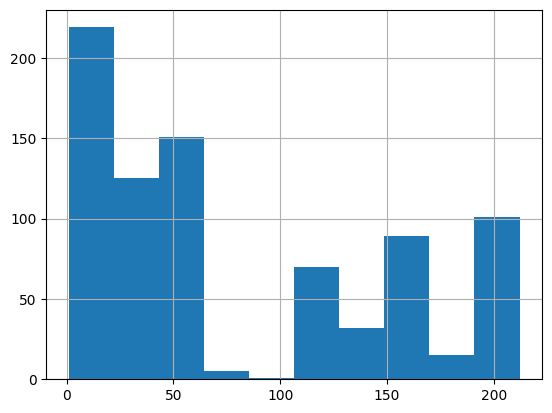

In [28]:
instance_counts['instance_uid'].hist()

In [22]:
df_metadata_dedup = df_metadata[['study_uid', 'series_uid', 'attribute_tag','value']].drop_duplicates()

In [26]:
df_metadata['study_description'].unique()

array(['ADNI3 Basic Prisma_20170209^ADNI3 Basic',
       'ADNI3 Basic Prisma^ADNI3 Basic', 'ADNI3 Basic Prisma^20181129',
       'SCREENING', 'MR BRAIN RESEARCH',
       'ADNI3 Basic Prisma^ADNI_MostRecent', 'YEAR 4', 'Yassine^DHA',
       'screening', 'e+1 MRI BRAIN W/O CONTRAST',
       'ADNI3 Advanced Prisma_20171012^ADNI3 Advanced', 'e+2 ADNI 3',
       'e+1 ADNI3', 'Year_1_Visit', 'ADNI3 Year2', 'year 2', 'YEAR_2'],
      dtype=object)

In [27]:
df_metadata['series_description'].unique()

array(['Perfusion_Weighted', 'Axial T2 STAR', 'Field Mapping',
       '3 Plane Localizer', 'Sagittal 3D FLAIR',
       'Axial 3D PASL (Eyes Open)', 'Accelerated Sagittal MPRAGE',
       'HighResHippocampus', 'Field Mapping_AP_Phase',
       'Axial 3TE T2 STAR',
       'HighResHippo Scan (Oblique - perpendicular to hippocampal tail',
       'Axial T2 Star', 'Axial Field Mapping', 'Axial 2D PASL',
       'Sagittal 3D Accelerated MPRAGE',
       'HighResHippocampus_AA prescan Normalize', 'tgse_pcasl_PLD2000',
       'Field Mapping_2.5mm', 'Calibration Scan', 'HighResHippo',
       'Accelerated Sagittal IR-FSPGR', 'Axial 3D pCASL (Eyes Open)',
       'Repeat_Accelerated Sagittal MPRAGE', 't1_fl2d_sag',
       'Repeat_Axial T2 STAR', '<MPR Collection>', 'cor mpr'],
      dtype=object)

In [23]:
df_metadata_dedup # 400,385

,study_uid,series_uid,attribute_tag,value
0,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00080005,ISO_IR 100
1,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00080008,DERIVED
2,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00080013,134748.218000
3,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00080020,20190806
4,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00080021,20190806
...,...,...,...,...
3966618,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00281051,5311
3966619,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00281052,-4096
3966620,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00281053,2.000244
3966621,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,0032000A,COMPLETED


In [35]:
df_metadata_dedup.groupby('attribute_tag')['value'].nunique().sort_values(ascending=False)[:20]

attribute_tag
00080013    59662
00080033    47257
00201041    34311
00200032    23377
00080032    15954
00281051    13235
00281050    10367
00080031      808
00181316      523
00180084      506
00200013      231
00209057      198
00080030       95
00400245       94
00080023       85
00080021       85
00080020       85
00080022       84
00101030       69
00180081       52
Name: value, dtype: int64

<Axes: >

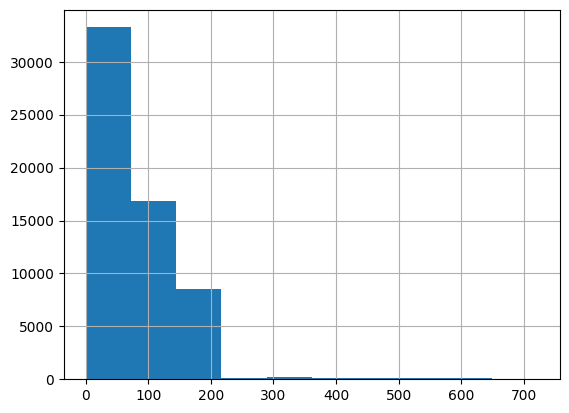

In [39]:
df_metadata_dedup[df_metadata_dedup['attribute_tag']=='00200013']['value'].hist()

In [28]:
df_metadata_dedup.to_pickle('./files/df_metadata_dedup_8.pkl')

In [27]:
import pandas as pd
df_metadata_dedup = pd.read_pickle('./files/df_metadata_dedup_6.pkl')

In [28]:
df_metadata_dedup.head()

,study_uid,series_uid,attribute_tag,value
0,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.0257367353967101811,00080005,ISO_IR 100
1,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.0257367353967101811,00080008,ORIGINAL
2,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.0257367353967101811,00080013,132300.791000
3,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.0257367353967101811,00080020,20200218
4,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.0257367353967101811,00080021,20200218


In [29]:
df_metadata_dedup.attribute_tag.nunique()

91

In [30]:
# PTID 00100020
# StudyDate (00080020)
# Acquisition Date (00080022)
# Study UID (0020000D)
# Series UID (0020000E)
# Series UID (00080018) – to count number of instances
# Study Description (00081030) 
# Series Description (0008103E)
# Modality (00080060)
# Body Part Examined (00180015)
# SOP Class UID (00080016)
df_subset = df_metadata_dedup[df_metadata_dedup['attribute_tag'].isin(['00100020', '00080020', '00080022', '00080018', '00081030', '0008103E', '00080060', '00180015', '00080016'])]
df_subset = df_subset.pivot(index=['study_uid', 'series_uid'], columns='attribute_tag', values='value').reset_index()
df_subset.head()

attribute_tag,study_uid,series_uid,00080020,00080022,00080060,00180015
0,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.0257367353967101811,20200218,20200218,MR,HEAD
1,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.02677408316883235540,20200218,20200218,MR,HEAD
2,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.06675742049047693160,20200218,20200218,MR,HEAD
3,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.08274858919129258141,20200218,20200218,MR,HEAD
4,2.16.124.113543.6006.99.3727626124013327188,2.16.124.113543.6006.99.1035056743807608511,20200218,20200218,MR,HEAD


In [20]:
df_subset.columns = ['study_uid', 'series_uid', 'study_date', 'acuisition_date', 'modality', 'body_part_examined']

In [21]:
df_subset

,study_uid,series_uid,study_date,acuisition_date,modality,body_part_examined
0,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,20190806,20190806,MR,BRAIN
1,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.08428228397778749671,20190806,20190806,MR,BRAIN
2,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.2054636274198166179,20190806,20190806,MR,BRAIN
3,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.7916726722310379853,20190806,20190806,MR,BRAIN
4,2.16.124.113543.6006.99.06706857867504247446,2.16.124.113543.6006.99.03671086227124482649,20170313,20170313,MR,BRAIN
...,...,...,...,...,...,...
803,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.08750092380025407058,20170615,20170615,MR,BRAIN
804,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.3300067167625826404,20170615,20170615,MR,BRAIN
805,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.4024297997348294533,20170615,20170615,MR,BRAIN
806,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.6295799475157931997,20170615,20170615,MR,BRAIN


## Download the image metadata and transform them

In [36]:
omop_image_concept[omop_image_concept['concept_id'].isin([2128000367, 2128000366, 2129001004, 2128000493])]

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
356,2128000366,Repetition Time,Measurement,DICOM,DICOM Attributes,NaN,00180080,19930101,20991231,NaN
357,2128000367,Echo Time,Measurement,DICOM,DICOM Attributes,NaN,00180081,19930101,20991231,NaN
483,2128000493,Flip Angle,Measurement,DICOM,DICOM Attributes,NaN,00181314,19930101,20991231,NaN


In [44]:
omop_image_concept[omop_image_concept['concept_code'] == '00870081']

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason


In [42]:
# 2128000367, 00180081 echo <= 10 
# 2128000366, 00180080 repetition time between 500 and 800
# 2128000493, 00181314 flip angle between 8 and 15
df_metadata_dedup[df_metadata_dedup['attribute_tag'].isin(['00180080', '00180081', '00181314', '00870081'])]

,study_uid,series_uid,attribute_tag,value
22,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00180080,4000
23,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00180081,20.26
36,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.0762513022255586274,00181314,180
83,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.08428228397778749671,00180080,650
84,2.16.124.113543.6006.99.06519376916392844499,2.16.124.113543.6006.99.08428228397778749671,00180081,20
...,...,...,...,...
3966464,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.6295799475157931997,00180081,16.02
3966477,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.6295799475157931997,00181314,180
3966583,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00180080,5000
3966584,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00180081,16.02


## Update Procedure_occurrence table

Required Fields: person_id, procedure_occurrence_id (PK), procedure_date, procedure_concept_id, procedure_type_concept_id
* Use patient ID (00100020) to get PTID then use registry_idmap to find the matching person_id
* Convert StudyDate (00080020) to procedure_date
* Series Description (00081030) to procedure_concept_id through Athena lookup - 36713262 (Brain MR)
* procedure_type_concept_id = 32817 - EHR
* Use Series UID to create procedure_occurrence_id

In [126]:
staging_table = pd.read_pickle('./files/image_occurrence_staging.pkl')
image_series = pd.read_pickle('./files/image_series_metadata.pkl')

In [127]:
staging_table.head()

,study_uid,series_uid,person_id,procedure_date,procedure_occurrence_id,image_occurrence_id,wadors_uri,anatomic_site_concept_id,modality_concept_id,visit_occurrence_id,visit_concept_id,visit_start_date,visit_end_date,visit_type_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2161,2017-12-04,1,1,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2161,2017-12-04,1,2,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2161,2017-12-04,1,3,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2161,2017-12-04,1,4,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2161,2017-12-04,1,5,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817


In [22]:
staging_table.groupby('person_id')['procedure_date'].nunique().reset_index().sort_values('procedure_date', ascending=False)

,person_id,procedure_date
12,2593,6
4,1594,6
11,2556,5
10,2372,4
20,3290,4
17,3015,4
2,1572,4
6,1858,3
30,3609,3
29,3477,3


In [26]:
# Create visit_occurrence_id
staging_table['visit_occurrence_id'] = staging_table.groupby(['person_id', 'procedure_date']).ngroup() + 1
staging_table.head()

,study_uid,series_uid,StudyUID,person_id,procedure_date,procedure_occurrence_id,image_occurrence_id,wadors_uri,anatomic_site_concept_id,modality_concept_id,visit_occurrence_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,1,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,2,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,3,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,4,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,5,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26


In [28]:
staging_table.groupby(['visit_occurrence_id']).nunique().reset_index().sort_values('procedure_date', ascending=False)

,visit_occurrence_id,study_uid,series_uid,StudyUID,person_id,procedure_date,procedure_occurrence_id,image_occurrence_id,wadors_uri,anatomic_site_concept_id,modality_concept_id
0,1,1,9,1,1,1,1,9,9,1,1
59,60,1,10,1,1,1,1,10,10,1,1
68,69,1,10,1,1,1,1,10,10,1,1
67,68,1,10,1,1,1,1,10,10,1,1
66,67,1,10,1,1,1,1,10,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...
29,30,1,9,1,1,1,1,9,9,1,1
28,29,1,9,1,1,1,1,9,9,1,1
27,28,1,13,1,1,1,1,13,13,1,1
26,27,1,10,1,1,1,1,10,10,1,1


In [29]:
staging_table['visit_concept_id'] = 9202 #outpatient visit
staging_table['visit_start_date'] = staging_table['procedure_date']
staging_table['visit_end_date'] = staging_table['procedure_date']
staging_table['visit_type_concept_id'] = 32817 #EHR

In [40]:
staging_table.to_pickle('./files/image_occurrence_staging.pkl')

In [ ]:
# PTID 00100020
# StudyDate (00080020)
# Acquisition Date (00080022)
# Study UID (0020000D)
# Series UID (0020000E)
# Study Description (00081030) 
# Modality (00080060)
# Body Part Examined (00180015)
# Series Description (0008103E)
# SOP Class UID (00080016)
# other instance level metadata into measurement and image_feature table
# filter out repetitive values per image series

In [3]:
# Extract information from metadata
def fetch_patient_details(base_url, headers):
    patient_data = []

    # Endpoint for fetching metadata of a study; adjust as needed
    metadata_url = f"{base_url}/studies/{study_uid}/metadata"

    # Fetch metadata for the current study
    metadata_response = requests.get(metadata_url, headers=headers)

    if metadata_response.status_code == 200:
        metadata = metadata_response.json()

        # Extract Patient ID, Gender, and Birth Date from the study metadata
        patient_id = metadata[0].get('00100020', {}).get('Value', [None])[0]
        study_uid = metadata[0].get("0020000D", {}).get("Value", [None])[0]
        series_uid = metadata[0].get("0020000E", {}).get("Value", [None])[0]
        study_description = metadata[0].get('00081030', {}).get('Value', [None])[0]
        study_date = metadata[0].get('00080020', {}).get('Value', [None])[0]
        acquisition_date = metadata[0].get('00080022', {}).get('Value', [None])[0]
        modality = metadata[0].get('00080060', {}).get('Value', [None])[0]
        body_part_examined = metadata[0].get('00180015', {}).get('Value', [None])[0]
        series_description = metadata[0].get('0008103E', {}).get('Value', [None])[0]
        sop_class_uid = metadata[0].get('00080016', {}).get('Value', [None])[0]

        patient_data.append({
            "StudyUID": study_uid,
            "SeriesUID": series_uid,
            "PatientID": patient_id,
            "Study_Description": study_description,
            "StudyDate": study_date,
            "AcquisitionDate": acquisition_date,
            "Modality": modality,
            "BodyPartExamined": body_part_examined,
            "SeriesDescription": series_description,
            "SOPClassUID": sop_class_uid
        })

    # Convert the list of records to a DataFrame
    return pd.DataFrame(patient_data)

In [6]:
headers = {
    'Authorization': 'Bearer ' + bearer_token,
    'Accept': 'application/dicom+json'
}
base_dicomweb_url = 'https://imgextpoc-adnidicom.dicom.azurehealthcareapis.com/v2'
patient_data = fetch_patient_details(base_dicomweb_url, headers)

In [8]:
patient_data.shape

(100, 9)

In [9]:
patient_data.head()

,StudyUID,PatientID,Study_Description,StudyDate,AcquisitionDate,Modality,BodyPartExamined,SeriesDescription,SOPClassUID
0,2.16.124.113543.6006.99.01060096421826160662,023_S_4448,ADNI3 Advanced Prisma_20171012^ADNI3 Advanced,20171204,20171204,MR,BRAIN,Field Mapping,1.2.840.10008.5.1.4.1.1.4
1,2.16.124.113543.6006.99.01145873998336190369,024_S_6385,Brain^lop-adni3,20180529,20180529,MR,BRAIN,Perfusion_Weighted,1.2.840.10008.5.1.4.1.1.4
2,2.16.124.113543.6006.99.01486454390863664241,027_S_2219,e+1 MR HEAD WITHOUT CONTRAST,20180206,20180206,MR,None,Calibration Scan,1.2.840.10008.5.1.4.1.1.4
3,2.16.124.113543.6006.99.0171281600952240178,027_S_2219,e+1 MR HEAD WITHOUT CONTRAST,20190207,20190207,MR,BRAIN,Calibration Scan,1.2.840.10008.5.1.4.1.1.4
4,2.16.124.113543.6006.99.0177008878696943993,024_S_6846,Brain^LOP-ADNI3,20210520,20210520,MR,BRAIN,Perfusion_Weighted,1.2.840.10008.5.1.4.1.1.4


In [ ]:
# # !!! redact before publishing !!!

# # Create database connection
# import pyodbc

# driver = '{ODBC Driver 18 for SQL Server}'
# server = 'tcp:ohdsicdm.database.windows.net'
# database = 'ohdsicdm'
# username = '<username>'
# password = '<password>'

# conn_str = f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'
# conn = pyodbc.connect(conn_str)
# cursor = conn.cursor()

In [41]:
import requests

response = requests.get('https://api.ipify.org?format=json')
ip_address = response.json()['ip']
print(f'My public IP address is: {ip_address}')

My public IP address is: 71.127.208.230


In [50]:
#host= ohdsicdmdb.postgres.database.azure.com, user= dbadmin, port=5432, database=adni, password=hopkinsx93ewD

import psycopg2

conn = psycopg2.connect(
    database="adni",
    user="dbadmin",
    password="hopkinsx93ewD",
    host="ohdsicdmdb.postgres.database.azure.com",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [21]:
# Update PROCERURE_OCCURRENCE
sql = '''
    INSERT INTO adni.procedure_occurrence (procedure_occurrence_id, person_id, procedure_concept_id, procedure_date, procedure_type_concept_id) 
    VALUES (%s,%s,%s,%s,%s)
    '''
for index, row in patient_details_df.iterrows():
    cursor.execute(sql, (row['procedure_occurrence_id'], row['person_id'], row['procedure_concept_id'], row['procedure_date'], row['procedure_type_concept_id']))

conn.commit()

In [72]:
sql = '''select * from dbo.procedure_occurrence'''
omop_procedure = pd.read_sql(sql, conn)

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_93686/1896854644.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  omop_procedure = pd.read_sql(sql, conn)


In [74]:
omop_procedure['visit_occurrence_id'].nunique()

93

In [62]:
# subset staging table to have two columns : procedure_occurrence_id, visit_occurrence_id
staging_table[['procedure_occurrence_id', 'visit_occurrence_id']]

,procedure_occurrence_id,visit_occurrence_id
0,1,26
1,1,26
2,1,26
3,1,26
4,1,26
...,...,...
884,93,73
885,94,64
886,94,64
887,94,64


In [64]:
omop_procedure = omop_procedure.merge(staging_table[['procedure_occurrence_id', 'visit_occurrence_id']], on='procedure_occurrence_id') #visit_occurrence_id_y
omop_procedure['visit_occurrence_id'] = omop_procedure['visit_occurrence_id_y']

,procedure_occurrence_id,person_id,procedure_concept_id,procedure_date,procedure_datetime,procedure_end_date,procedure_end_datetime,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id_x,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value,visit_occurrence_id_y,visit_occurrence_id
0,1,2161,36713262,2017-12-04,None,None,None,32817,None,None,None,None,None,None,None,None,26,26
1,1,2161,36713262,2017-12-04,None,None,None,32817,None,None,None,None,None,None,None,None,26,26
2,1,2161,36713262,2017-12-04,None,None,None,32817,None,None,None,None,None,None,None,None,26,26
3,1,2161,36713262,2017-12-04,None,None,None,32817,None,None,None,None,None,None,None,None,26,26
4,1,2161,36713262,2017-12-04,None,None,None,32817,None,None,None,None,None,None,None,None,26,26


In [66]:
omop_procedure = omop_procedure.drop(columns=['visit_occurrence_id_x', 'visit_occurrence_id_y'], axis = 1)

In [56]:
# Update Visit_OCCURRENCE
sql = '''
    INSERT INTO dbo.visit_occurrence (visit_occurrence_id, person_id, visit_concept_id, visit_start_date, visit_end_date, visit_type_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s)
    '''
for index, row in staging_table.iterrows():
    cursor.execute(sql, (row['visit_occurrence_id'], row['person_id'], row['visit_concept_id'], row['visit_start_date'], row['visit_end_date'], row['visit_type_concept_id']))

conn.commit()

In [70]:
sql = 'DELETE from dbo.procedure_occurrence'
cursor.execute(sql)
conn.commit()

In [71]:
# Update PROCERURE_OCCURRENCE
sql = '''
    INSERT INTO dbo.procedure_occurrence (procedure_occurrence_id, person_id, procedure_concept_id, procedure_date, procedure_type_concept_id, visit_occurrence_id) 
    VALUES (%s,%s,%s,%s,%s,%s)
    '''
for index, row in omop_procedure.iterrows():
    cursor.execute(sql, (row['procedure_occurrence_id'], row['person_id'], row['procedure_concept_id'], row['procedure_date'], row['procedure_type_concept_id'], row['visit_occurrence_id']))

conn.commit()

## Update Image_occurrence table

* PK, FK: image_occurrence_id, person_id, procedure_occurrence_id, visit_occurrence_id, 
* Concept IDs: anatomic_site_concept_id (0018,0015) - snomed, modality_concept_id (0008,0060)
* wadors_uri, local_path (NA), image_occurrence_date (0008,0022), image_study_UID (0020,000D), series_UID (0020,0010)

In [ ]:
image_occurrence_staging = series_attributes[["Study_UID", "Series_UID"]].drop_duplicates()
image_occurrence_staging

In [ ]:
image_occurrence_staging = image_occurrence_staging.merge(patient_details_df[["StudyUID", "person_id", "procedure_date", "procedure_occurrence_id"]], left_on= "study_uid", right_on = 'StudyUID', how = 'left')

# Image occurrence ID
image_occurrence_staging['image_occurrence_id'], _ = pd.factorize(image_occurrence_staging['series_uid'])
image_occurrence_staging['image_occurrence_id'] = image_occurrence_staging['image_occurrence_id'] + 1 

# WADORS-URI
base_dicom_uri = 'https://imgextpoc-adnidicom.dicom.azurehealthcareapis.com/v2'
image_occurrence_staging['wadors_uri'] = base_dicom_uri + '/studies/' + image_occurrence_staging['study_uid'] + '/series/' + image_occurrence_staging['series_uid']

# Others
image_occurrence_staging['anatomic_site_concept_id'] = 4119359
image_occurrence_staging['modality_concept_id'] = 4013636

image_occurrence_staging

In [22]:
image_occurrence_staging = pd.read_pickle('./files/image_occurrence_staging.pkl')
image_occurrence_staging.head()

,study_uid,series_uid,StudyUID,person_id,procedure_date,procedure_occurrence_id,image_occurrence_id,wadors_uri,anatomic_site_concept_id,modality_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,1,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,2,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,3,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,4,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2.16.124.113543.6006.99.01060096421826160662,2161,2017-12-04,1,5,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636


In [63]:
# Update IMAGE_OCCURRENCE
sql = '''
    INSERT INTO adni.image_occurrence (image_occurrence_id, person_id, procedure_occurrence_id, anatomic_site_concept_id, wadors_uri, image_occurrence_date, image_study_uid, image_series_uid, modality_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in image_occurrence_staging.iterrows():
    cursor.execute(sql, (row['image_occurrence_id'], row['person_id'], row['procedure_occurrence_id'],  row['anatomic_site_concept_id'], row['wadors_uri'], row['procedure_date'],
                    row['study_uid'], row['series_uid'], row['modality_concept_id']))

conn.commit()

## Update Measurement table

* Numeric and non-numeric values have different fields
* One Image_feature row has one Measurement row.
* Create one stage table for Measurement and Image_feature input data.
* Required fields: measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number, measurement_source_value 

## Update Image_feature table

* PK, FK: image_feature_id, person_id, image_occurrence_id, image_feature_event_id
* Clinical domain: image_feature_event_field_concept_id (1147330 = measurement table)
* image_feature_concept_id: matching tags from the staging table 
* image_feature_type_concept_id: acquisition parameter (add a new concept id? can I use the concept class id?)
* anatomic_site_concept_id: for acquisition parameter, same as (0018,0015) - snomed

In [24]:
series_attributes = pd.read_pickle('./files/image_series_metadata.pkl')
series_attributes.head()

,Study_UID,Series_UID,Attribute Tag,Value,concept_id,concept_name,value_as_number,image_feature_id,measurement_id,measurement_type_concept_id,image_occurrence_date,person_id,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,ISO_IR 100,2128000011,Specific Character Set,NaN,1,1,32817,2017-12-04,2161,1,1147330,4119359
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,ORIGINAL,2128000012,Image Type,NaN,2,2,32817,2017-12-04,2161,1,1147330,4119359
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080013,132059.935000,2128000014,Instance Creation Time,NaN,3,3,32817,2017-12-04,2161,1,1147330,4119359
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080020,20171204,2128000016,Study Date,NaN,4,4,32817,2017-12-04,2161,1,1147330,4119359
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080021,20171204,2128000017,Series Date,NaN,5,5,32817,2017-12-04,2161,1,1147330,4119359


In [28]:
agg_attr = series_attributes.groupby(['Study_UID', 'Series_UID', 'Attribute Tag']).size().reset_index(name='counts')

In [49]:
# Echo time 2128000367 (less or equal than 10 )
# Repetition time 2128000366 (values between 500 and 800 )
# Inversion time 2128000368 (values between 900 1100 )
# Flip angle 2128000493 (values between 8 and 15)
# Field of view 2128000378 (values between 220 and 250 )
# max int value = 2,147,483,647
# Number of slices 2128001004 (above 150) -> count the number of slices and put it as 2129001004

attr_list = [2128000367, 2128000366, 2128000368, 2128000493, 2128000378]

In [30]:
series_attributes[series_attributes['Series_UID'].isin(agg_attr[agg_attr['counts'] > 1]['Series_UID'])]['concept_name'].unique()

array(['Specific Character Set', 'Image Type', 'Instance Creation Time',
       'Study Date', 'Series Date', 'Acquisition Date', 'Content Date',
       'Study Time', 'Series Time', 'Acquisition Time', 'Content Time',
       'Modality', "Patient's Sex", "Patient's Size", "Patient's Weight",
       'Body Part Examined', 'Scanning Sequence', 'Sequence Variant',
       'Scan Options', 'MR Acquisition Type', 'Angio Flag',
       'Slice Thickness', 'Repetition Time', 'Echo Time',
       'Inversion Time', 'Number of Averages', 'Imaging Frequency',
       'Echo Number(s)', 'Magnetic Field Strength',
       'Number of Phase Encoding Steps', 'Echo Train Length',
       'Percent Sampling', 'Percent Phase Field of View',
       'Pixel Bandwidth', 'Acquisition Matrix',
       'In-plane Phase Encoding Direction', 'Flip Angle',
       'Variable Flip Angle Flag', 'SAR', 'dB/dt', 'Patient Position',
       'Series Number', 'Acquisition Number', 'Instance Number',
       'Image Position (Patient)', 'Ima

In [39]:
series_attr_to_load = series_attributes[series_attributes['Attribute Tag'].isin(agg_attr[agg_attr['counts'] == 1]['Attribute Tag'])]
series_attr_to_load

,Study_UID,Series_UID,Attribute Tag,Value,concept_id,concept_name,value_as_number,image_feature_id,measurement_id,measurement_type_concept_id,image_occurrence_date,person_id,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,ISO_IR 100,2128000011,Specific Character Set,NaN,1,1,32817,2017-12-04,2161,1,1147330,4119359
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,ORIGINAL,2128000012,Image Type,NaN,2,2,32817,2017-12-04,2161,1,1147330,4119359
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080013,132059.935000,2128000014,Instance Creation Time,NaN,3,3,32817,2017-12-04,2161,1,1147330,4119359
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080020,20171204,2128000016,Study Date,NaN,4,4,32817,2017-12-04,2161,1,1147330,4119359
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080021,20171204,2128000017,Series Date,NaN,5,5,32817,2017-12-04,2161,1,1147330,4119359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485022,2.16.124.113543.6006.99.9035087760856874683,2.16.124.113543.6006.99.8706306584783342182,00281050,-306,2128001273,Window Center,-306,485023,485023,32817,2018-03-16,3223,948,1147330,4119359
485023,2.16.124.113543.6006.99.9035087760856874683,2.16.124.113543.6006.99.8706306584783342182,00281051,5377,2128001274,Window Width,5377,485024,485024,32817,2018-03-16,3223,948,1147330,4119359
485024,2.16.124.113543.6006.99.9035087760856874683,2.16.124.113543.6006.99.8706306584783342182,00281052,-4096,2128001275,Rescale Intercept,-4096,485025,485025,32817,2018-03-16,3223,948,1147330,4119359
485025,2.16.124.113543.6006.99.9035087760856874683,2.16.124.113543.6006.99.8706306584783342182,00281053,2.000244,2128001276,Rescale Slope,2.000244,485026,485026,32817,2018-03-16,3223,948,1147330,4119359


In [66]:
instance_attr_to_load = series_attr_to_load[series_attr_to_load['concept_id'].isin(attr_list)]
instance_attr_to_load.head()

,Study_UID,Series_UID,Attribute Tag,Value,concept_id,concept_name,value_as_number,image_feature_id,measurement_id,measurement_type_concept_id,image_occurrence_date,person_id,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id
22,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180080,2300,2128000366,Repetition Time,2300,23,23,32817,2017-12-04,2161,1,1147330,4119359
23,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180081,2.98,2128000367,Echo Time,2.98,24,24,32817,2017-12-04,2161,1,1147330,4119359
24,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180082,900,2128000368,Inversion Time,900,25,25,32817,2017-12-04,2161,1,1147330,4119359
32,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180094,93.75,2128000378,Percent Phase Field of View,93.75,33,33,32817,2017-12-04,2161,1,1147330,4119359
36,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00181314,9,2128000493,Flip Angle,9,37,37,32817,2017-12-04,2161,1,1147330,4119359


In [40]:
series_attr_to_load['value_as_number'] = series_attr_to_load['value_as_number'].fillna(0)

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_95336/2483624578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_attr_to_load['value_as_number'] = series_attr_to_load['value_as_number'].fillna(0)


In [44]:
series_attr_to_load = series_attr_to_load[series_attr_to_load['value_as_number']!='']

In [55]:
import psycopg2

conn = psycopg2.connect(
    database="postgres",
    user="postgres",
    password="hopkinsdb",
    host="20.190.196.193",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [48]:
# Update MEASUREMENT
sql = '''
    INSERT INTO adni.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number, measurement_source_value) 
    VALUES (%s,%s,%s,%s,%s,%s,%s)
'''

# Define batch size
batch_size = 20000
batch = []

# Iterate through the DataFrame
for index, row in series_attr_to_load.iterrows():
    # Append row data to the batch
    batch.append((row['measurement_id'], row['person_id'], row['concept_id'], row['image_occurrence_date'], row['measurement_type_concept_id'], row['value_as_number'], row['Value']))

    # Check if batch size is reached or if it's the last row
    if len(batch) == batch_size or (index == len(series_attr_to_load) - 1):
        # Execute the batch
        cursor.executemany(sql, batch)
        conn.commit()  # Commit after each batch
        batch = []  # Clear the batch for the next set of rows

In [64]:
# Update IMAGE_FEATURE
# numeric data
sql = '''
    INSERT INTO adni.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
'''

# Define batch size
batch_size = 20000
batch = []

# Iterate through the DataFrame
for index, row in series_attr_to_load.iterrows():
    # Append row data to the batch
    batch.append((row['image_feature_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  row['image_feature_event_field_concept_id'], row['concept_id'], row['measurement_type_concept_id'],
                  row['anatomic_site_concept_id']))

    # Check if batch size is reached or if it's the last row
    if len(batch) == batch_size or (index == len(series_attributes) - 1):
        # Execute the batch
        cursor.executemany(sql, batch)
        conn.commit()  # Commit after each batch
        batch = []  # Clear the batch for the next set of rows

# Close the cursor and connection
cursor.close()
conn.close()

### Instance level attributes

In [91]:
# upload instance level attributes
import psycopg2

conn = psycopg2.connect(
    database="postgres",
    user="postgres",
    password="hopkinsdb",
    host="20.190.196.193",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [77]:
# Update MEASUREMENT
sql = '''
    INSERT INTO adni.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number, measurement_source_value) 
    VALUES (%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in instance_attr_to_load.iterrows():
    cursor.execute(sql, (row['measurement_id'], row['person_id'], row['concept_id'], row['image_occurrence_date'], row['measurement_type_concept_id'], row['value_as_number'], row['Value']))

conn.commit()

In [78]:
# Update IMAGE_FEATURE
sql = '''
    INSERT INTO adni.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in instance_attr_to_load.iterrows():
    cursor.execute(sql, (row['image_feature_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  row['image_feature_event_field_concept_id'], row['concept_id'], row['measurement_type_concept_id'],
                  row['anatomic_site_concept_id']))

conn.commit()

#### Custom concept for instance slices 

In [ ]:
# Update CONCEPT with new concept id for number of slices (counted), not from DICOM tag
cursor = conn.cursor()

sql = '''
    INSERT INTO adni.concept (concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason)
    VALUES (2129001004, 'Number of slices - count', 'Measurement', 'DICOM', 'DICOM Attributes', '', 0, '2099-12-31', '1993-01-01', '')
    '''
cursor.execute(sql)
conn.commit()

In [79]:
instance_attr_to_load.head()

,Study_UID,Series_UID,Attribute Tag,Value,concept_id,concept_name,value_as_number,image_feature_id,measurement_id,measurement_type_concept_id,image_occurrence_date,person_id,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id
22,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180080,2300,2128000366,Repetition Time,2300,23,23,32817,2017-12-04,2161,1,1147330,4119359
23,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180081,2.98,2128000367,Echo Time,2.98,24,24,32817,2017-12-04,2161,1,1147330,4119359
24,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180082,900,2128000368,Inversion Time,900,25,25,32817,2017-12-04,2161,1,1147330,4119359
32,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180094,93.75,2128000378,Percent Phase Field of View,93.75,33,33,32817,2017-12-04,2161,1,1147330,4119359
36,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00181314,9,2128000493,Flip Angle,9,37,37,32817,2017-12-04,2161,1,1147330,4119359


In [103]:
instance_counts = series_attributes.groupby(['Study_UID', 'Series_UID', 'person_id', 'image_occurrence_date', 'image_occurrence_id', 'image_feature_event_field_concept_id', 'anatomic_site_concept_id']).size().reset_index(name='counts')
instance_counts.head()

,Study_UID,Series_UID,person_id,image_occurrence_date,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id,counts
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2161,2017-12-04,1,1147330,4119359,1294
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2161,2017-12-04,2,1147330,4119359,75
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2161,2017-12-04,3,1147330,4119359,61
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2161,2017-12-04,4,1147330,4119359,678
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2161,2017-12-04,5,1147330,4119359,206


In [11]:
instance_counts = image_series.groupby(['Study_UID', 'Series_UID', 'person_id', 'image_occurrence_date', 'image_occurrence_id', 'image_feature_event_field_concept_id', 'anatomic_site_concept_id']).size().reset_index(name='counts')
instance_counts.head()

,Study_UID,Series_UID,person_id,image_occurrence_date,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id,counts
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2161,2017-12-04,1,1147330,4119359,1294
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2161,2017-12-04,2,1147330,4119359,75
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2161,2017-12-04,3,1147330,4119359,61
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2161,2017-12-04,4,1147330,4119359,678
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2161,2017-12-04,5,1147330,4119359,206


In [13]:
print(image_series.measurement_id.max())
print(image_series.image_feature_id.max())

485027
485027


In [14]:
instance_counts['Value'] = instance_counts['counts']
instance_counts['concept_id'] = 2129001004
instance_counts['value_as_number'] = instance_counts['counts']
instance_counts['measurement_id'] = 485028 + instance_counts.index
instance_counts['measurement_type_concept_id'] = 32817

instance_counts.shape

(948, 13)

In [15]:
instance_counts.head()

,Study_UID,Series_UID,person_id,image_occurrence_date,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id,counts,Value,concept_id,value_as_number,measurement_id,measurement_type_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2161,2017-12-04,1,1147330,4119359,1294,1294,2129001004,1294,485028,32817
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2161,2017-12-04,2,1147330,4119359,75,75,2129001004,75,485029,32817
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2161,2017-12-04,3,1147330,4119359,61,61,2129001004,61,485030,32817
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2161,2017-12-04,4,1147330,4119359,678,678,2129001004,678,485031,32817
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2161,2017-12-04,5,1147330,4119359,206,206,2129001004,206,485032,32817


In [17]:
# Update MEASUREMENT
sql = '''
    INSERT INTO dbo.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number, measurement_source_value, measurement_source_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in instance_counts.iterrows():
    cursor.execute(sql, (row['measurement_id'], row['person_id'], row['concept_id'], row['image_occurrence_date'], row['measurement_type_concept_id'], row['value_as_number'], row['Value'], row['concept_id']))

conn.commit()

In [18]:
# Update IMAGE_FEATURE
sql = '''
    INSERT INTO dbo.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in instance_counts.iterrows():
    cursor.execute(sql, (row['measurement_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  row['image_feature_event_field_concept_id'], row['concept_id'], row['measurement_type_concept_id'],
                  row['anatomic_site_concept_id']))

conn.commit()

In [122]:
df = df_measurement_final.merge(df_concept, left_on = 'measurement_source_concept_id', right_on = 'concept_id')

In [127]:
concepts = df.groupby('concept_name').nunique()

In [128]:
concepts

,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,meas_event_field_concept_id,concept_id,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
concept_name,,,,,,,,,,,,,,,,,,,,,
Acquisition Contrast,92,7,1,6,0,0,1,0,1,0,...,0,1,1,1,1,1,1,1,1,1
Acquisition Date,833,36,1,84,0,0,1,0,1,0,...,0,1,1,1,1,1,1,1,1,1
Acquisition Duration,110,7,1,6,0,0,1,0,15,0,...,0,1,1,1,1,1,1,1,1,1
Acquisition Matrix,898,36,1,84,0,0,1,0,1,0,...,0,1,1,1,1,1,1,1,1,1
Acquisition Number,8820,36,1,90,0,0,1,0,976,0,...,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Volumetric Properties,92,7,1,6,0,0,1,0,1,0,...,0,1,1,1,1,1,1,1,1,1
Window Center,45194,36,1,84,0,0,1,0,3951,0,...,0,1,1,1,1,1,1,1,1,1
Window Width,50597,36,1,84,0,0,1,0,6445,0,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
# Echo time 2128000367 (less or equal than 10 )
# Repetition time 2128000366 (values between 500 and 800 )
# Inversion time 2128000368 (values between 900 1100 )
# Flip angle 2128000493 (values between 8 and 15)
# Field of view 2128000378 (values between 220 and 250 )
# max int value = 2,147,483,647
# Number of slices 2128001004 (above 150) -> count the number of slices and put it as 2129001004

In [19]:
sql = '''select * from dbo.measurement where measurement_concept_id > 2000000000'''
omop_measurement = pd.read_sql(sql, conn)

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_13203/3366930718.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  omop_measurement = pd.read_sql(sql, conn)


In [20]:
omop_measurement.describe()

,measurement_id,person_id,measurement_concept_id,measurement_type_concept_id,value_as_number,measurement_source_concept_id
count,463309.000000,463309.000000,4.633090e+05,463309.0,463309.000000,4.633090e+05
mean,237433.606073,2752.812637,2.128005e+09,32817.0,365.285973,2.128005e+09
std,136368.030748,807.056356,6.386207e+04,0.0,1117.531586,6.386207e+04
min,1.000000,75.000000,2.128000e+09,32817.0,-4096.000000,2.128000e+09
25%,120602.000000,2161.000000,2.128000e+09,32817.0,0.000000,2.128000e+09
50%,237061.000000,3015.000000,2.128001e+09,32817.0,1.000000,2.128001e+09
75%,354042.000000,3336.000000,2.128001e+09,32817.0,114.000000,2.128001e+09
max,485975.000000,3805.000000,2.129001e+09,32817.0,19541.000000,2.129001e+09


In [21]:
omop_measurement['person_id'].nunique()

37

In [ ]:
omop_measurement

<Axes: >

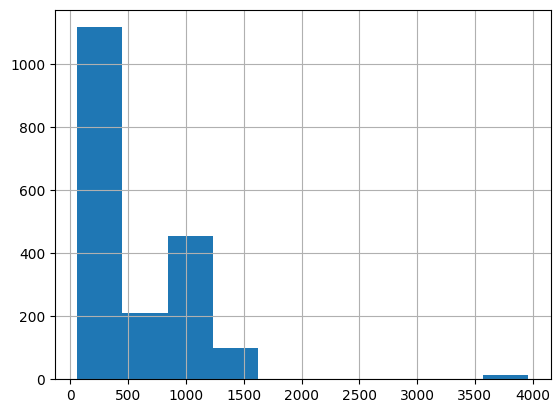

In [23]:
omop_measurement[omop_measurement['measurement_source_concept_id']==2129001004]['value_as_number'].hist()

In [28]:
omop_measurement[(omop_measurement['measurement_source_concept_id']==2129001004) & (omop_measurement['value_as_number'] > 140)]

,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
461404,485028,2161,2129001004,2017-12-04,None,None,32817,None,1294.0,None,...,None,None,None,1294,2129001004,None,None,None,None,None
461407,485031,2161,2129001004,2017-12-04,None,None,32817,None,678.0,None,...,None,None,None,678,2129001004,None,None,None,None,None
461408,485032,2161,2129001004,2017-12-04,None,None,32817,None,206.0,None,...,None,None,None,206,2129001004,None,None,None,None,None
461409,485033,2161,2129001004,2017-12-04,None,None,32817,None,867.0,None,...,None,None,None,867,2129001004,None,None,None,None,None
461410,485034,2161,2129001004,2017-12-04,None,None,32817,None,839.0,None,...,None,None,None,839,2129001004,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463302,485969,3223,2129001004,2018-03-16,None,None,32817,None,170.0,None,...,None,None,None,170,2129001004,None,None,None,None,None
463303,485970,3223,2129001004,2018-03-16,None,None,32817,None,1280.0,None,...,None,None,None,1280,2129001004,None,None,None,None,None
463304,485971,3223,2129001004,2018-03-16,None,None,32817,None,868.0,None,...,None,None,None,868,2129001004,None,None,None,None,None
463306,485973,3223,2129001004,2018-03-16,None,None,32817,None,992.0,None,...,None,None,None,992,2129001004,None,None,None,None,None


In [78]:
sql = '''select * from dbo.image_feature'''
omop_image_feature = pd.read_sql(sql, conn)

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_93686/2487770237.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  omop_image_feature = pd.read_sql(sql, conn)


In [79]:
omop_image_feature.describe()

,image_feature_id,person_id,image_occurrence_id,image_feature_event_field_concept_id,image_feature_event_id,image_feature_concept_id,image_feature_type_concept_id,anatomic_site_concept_id
count,476127.000000,476127.000000,476127.000000,476127.0,476127.000000,4.761270e+05,476127.0,476127.0
mean,243899.229325,2753.697306,473.554951,1147330.0,243899.229325,2.128003e+09,32817.0,4119359.0
std,140024.889471,806.428229,273.607775,0.0,140024.889471,4.459389e+04,0.0,0.0
min,1.000000,75.000000,1.000000,1147330.0,1.000000,2.128000e+09,32817.0,4119359.0
25%,124355.000000,2161.000000,246.000000,1147330.0,124355.000000,2.128000e+09,32817.0,4119359.0
50%,243421.000000,3015.000000,470.000000,1147330.0,243421.000000,2.128001e+09,32817.0,4119359.0
75%,364097.500000,3336.000000,704.000000,1147330.0,364097.500000,2.128001e+09,32817.0,4119359.0
max,485975.000000,3805.000000,948.000000,1147330.0,485975.000000,2.129001e+09,32817.0,4119359.0


In [80]:
omop_image_feature['person_id'].nunique()

37

In [22]:
cursor.close()
conn.close()

In [89]:
obs_period = omop_procedure.groupby('person_id')['procedure_date'].agg(['max', 'min']).reset_index() #32817
obs_period['observation_period_id'] = range(1,36,1)
obs_period['period_type_concept_id'] = 32817

In [98]:
obs_period.to_csv('./files/obs_period.csv')

In [2]:
import pandas as pd
obs_period = pd.read_csv('./files/obs_period.csv')

In [1]:
# upload instance level attributes
import psycopg2

#host= ohdsicdmdb.postgres.database.azure.com, user= dbadmin, port=5432, database=adni, password=hopkinsx93ewD

conn = psycopg2.connect(
    database="adni",
    user="dbadmin",
    password="hopkinsx93ewD",
    host="ohdsicdmdb.postgres.database.azure.com",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [10]:
cursor.close()
conn.close()

In [7]:
# Update OBSERVATION_PERIOD
sql = '''
    INSERT INTO dbo.observation_period (observation_period_id, person_id, observation_period_start_date, observation_period_end_date, period_type_concept_id) 
    VALUES (%s,%s,%s,%s,%s)
    '''
for index, row in obs_period.iterrows():
    cursor.execute(sql, (row['observation_period_id'], row['person_id'], row['min'], row['max'], row['period_type_concept_id']))

conn.commit()

In [8]:
sql = 'select * from dbo.observation_period'
obs_period = pd.read_sql(sql, conn)
obs_period.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_678/3176792398.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  obs_period = pd.read_sql(sql, conn)


,observation_period_id,person_id,observation_period_start_date,observation_period_end_date,period_type_concept_id
0,1,75,2019-01-24,2021-01-21,32817
1,2,134,2017-04-13,2017-04-13,32817
2,3,1572,2017-04-19,2020-01-27,32817
3,4,1580,2018-03-20,2021-10-20,32817
4,5,1594,2017-02-01,2022-01-27,32817


In [9]:
obs_period

,observation_period_id,person_id,observation_period_start_date,observation_period_end_date,period_type_concept_id
0,1,75,2019-01-24,2021-01-21,32817
1,2,134,2017-04-13,2017-04-13,32817
2,3,1572,2017-04-19,2020-01-27,32817
3,4,1580,2018-03-20,2021-10-20,32817
4,5,1594,2017-02-01,2022-01-27,32817
5,6,1812,2017-08-11,2021-08-11,32817
6,7,1858,2020-01-13,2022-01-28,32817
7,8,1885,2017-12-18,2021-12-21,32817
8,9,1894,2017-08-31,2017-08-31,32817
9,10,2161,2017-12-04,2022-01-03,32817


## Debug Atlas

In [25]:
# upload instance level attributes
import psycopg2

#host= ohdsicdmdb.postgres.database.azure.com, user= dbadmin, port=5432, database=adni, password=hopkinsx93ewD

conn = psycopg2.connect(
    database="adni",
    user="dbadmin",
    password="hopkinsx93ewD",
    host="ohdsicdmdb.postgres.database.azure.com",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [28]:
sql = '''
    update dbo.measurement 
    set measurement_concept_id = measurement_source_concept_id
    where measurement_source_concept_id > 2000000000
    '''
cursor.execute(sql)
conn.commit()

In [29]:
sql = '''select * from dbo.measurement where measurement_concept_id > 2000000000'''
omop_measurement = pd.read_sql(sql, conn)
omop_measurement.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_678/1045349359.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  omop_measurement = pd.read_sql(sql, conn)


,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
0,21658,3805,2128000011,2021-05-20,None,None,32817,None,0.0,None,...,None,None,None,ISO_IR 100,2128000011,None,None,None,None,None
1,22527,3805,2128000011,2021-05-20,None,None,32817,None,0.0,None,...,None,None,None,ISO_IR 100,2128000011,None,None,None,None,None
2,23380,3290,2128000011,2021-05-12,None,None,32817,None,0.0,None,...,None,None,None,ISO_IR 100,2128000011,None,None,None,None,None
3,23633,3290,2128000011,2021-05-12,None,None,32817,None,0.0,None,...,None,None,None,ISO_IR 100,2128000011,None,None,None,None,None
4,24493,3290,2128000011,2021-05-12,None,None,32817,None,0.0,None,...,None,None,None,ISO_IR 100,2128000011,None,None,None,None,None


In [30]:
cursor.close()
conn.close()

In [9]:
image_series[image_series['concept_name']=="Number of slices - count"]

,Study_UID,Series_UID,Attribute Tag,Value,concept_id,concept_name,value_as_number,image_feature_id,measurement_id,measurement_type_concept_id,image_occurrence_date,person_id,image_occurrence_id,image_feature_event_field_concept_id,anatomic_site_concept_id


## Add brain volume to OMOP CDM

### Import files

In [1]:
cd ..

/Users/wooyeonpark/Documents/GitHub/DICOM2OMOP


In [14]:
import pandas as pd
#first run
df_vol = pd.read_csv("./files/cohort1_testseries_openmapt1_results.csv")
df_vol.head()

,study_uid,series_uid,SFG_L,SFG_R,SFG_PFC_L,SFG_PFC_R,SFG_pole_L,SFG_pole_R,MFG_L,MFG_R,...,Fimbria_R,Chroid_LVetc_L,Chroid_LVetc_R,IV_ventricle,ECCL_L,ECCL_R,ECSAnterior_L,ECSAnterior_R,ECSPosterior_L,ECSPosterior_R
0,2.16.124.113543.6006.99.02146034564549802647,2.16.124.113543.6006.99.02146034564549802647,12542.0,12067.0,10605.0,9312.0,2305.0,3552.0,8286.0,9066.0,...,0.0,177.0,168.0,1568.0,421.0,551.0,3207.0,3514.0,2622.0,2798.0
1,2.16.124.113543.6006.99.02156281418585922950,2.16.124.113543.6006.99.02156281418585922950,15217.0,14315.0,10326.0,10305.0,1862.0,4190.0,8413.0,7461.0,...,0.0,356.0,247.0,2621.0,322.0,367.0,4873.0,4113.0,5259.0,5717.0
2,2.16.124.113543.6006.99.993407831381508223,2.16.124.113543.6006.99.993407831381508223,15451.0,15439.0,10445.0,11327.0,2320.0,4734.0,10340.0,9972.0,...,0.0,670.0,410.0,2662.0,344.0,494.0,3297.0,4894.0,4634.0,3549.0
3,2.16.124.113543.6006.99.7084724843781950414,2.16.124.113543.6006.99.7084724843781950414,14793.0,12882.0,10043.0,11147.0,2297.0,4078.0,8145.0,8026.0,...,0.0,255.0,240.0,2299.0,406.0,436.0,6760.0,5479.0,5358.0,4489.0
4,2.16.124.113543.6006.99.01664766563067247342,2.16.124.113543.6006.99.01664766563067247342,14887.0,12869.0,9516.0,10474.0,2421.0,4279.0,8176.0,7751.0,...,0.0,260.0,253.0,2207.0,370.0,459.0,7310.0,5978.0,5763.0,4633.0


In [2]:
import pandas as pd
# additional volumetrics
df_vol = pd.read_csv("./files/brain_vol_06262024.csv")
df_vol.head()

,study_id,series_id,SFG_L,SFG_R,SFG_PFC_L,SFG_PFC_R,SFG_pole_L,SFG_pole_R,MFG_L,MFG_R,...,Fimbria_R,Chroid_LVetc_L,Chroid_LVetc_R,IV_ventricle,ECCL_L,ECCL_R,ECSAnterior_L,ECSAnterior_R,ECSPosterior_L,ECSPosterior_R
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,13696.0,11047.0,8967.0,9127.0,2699.0,3769.0,8050.0,8104.0,...,2.0,242.0,164.0,2769.0,405.0,445.0,2728.0,4822.0,2528.0,3880.0
1,2.16.124.113543.6006.99.01145873998336190369,2.16.124.113543.6006.99.1175567928230712121,16732.0,16505.0,11844.0,12626.0,2855.0,5242.0,11882.0,10237.0,...,0.0,256.0,255.0,1822.0,539.0,530.0,5429.0,4661.0,3661.0,2730.0
2,2.16.124.113543.6006.99.01486454390863664241,2.16.124.113543.6006.99.05538929075952892099,15687.0,15349.0,10539.0,11378.0,2587.0,5050.0,10616.0,10159.0,...,0.0,665.0,393.0,2690.0,367.0,494.0,3325.0,4564.0,3991.0,3939.0
3,2.16.124.113543.6006.99.0171281600952240178,2.16.124.113543.6006.99.07785233623659097184,15995.0,14917.0,10656.0,10989.0,2689.0,4962.0,10485.0,9950.0,...,0.0,681.0,439.0,2727.0,342.0,455.0,3682.0,4856.0,4109.0,3629.0
4,2.16.124.113543.6006.99.0177008878696943993,2.16.124.113543.6006.99.0179716961251050726,15596.0,12272.0,10586.0,10534.0,2251.0,4390.0,8185.0,11233.0,...,0.0,286.0,267.0,2700.0,356.0,509.0,7705.0,6229.0,5601.0,6773.0


In [8]:
df_vol.shape

(88, 282)

In [3]:
concept_vol = pd.read_csv('./files/concept_vol_brain.csv')
series_to_exclude = pd.read_csv('./files/series_to_exclude.csv')

In [4]:
series_to_exclude.head()

,image_series_uid
0,2.16.124.113543.6006.99.02146034564549802647
1,2.16.124.113543.6006.99.02156281418585922950
2,2.16.124.113543.6006.99.993407831381508223
3,2.16.124.113543.6006.99.7084724843781950414
4,2.16.124.113543.6006.99.01664766563067247342


In [9]:
#exclude ones we already uploaded
df_vol = df_vol[~df_vol['series_id'].isin(series_to_exclude['image_series_uid'])].copy().reset_index(drop=True)
df_vol.shape

(62, 282)

In [15]:
import pandas as pd

vol_name = pd.read_csv("./files/openmap_colnames.csv")
vol_name.head()

,name,full_name
0,SFG_L,Superior Frontal Gyrus (Posterior Segment) Left
1,SFG_R,Superior Frontal Gyrus (Posterior Segment) Right
2,SFG_PFC_L,Superior Frontal Gyrus (Prefrontal Cortex) Left
3,SFG_PFC_R,Superior Frontal Gyrus (Prefrontal Cortex) Right
4,SFG_pole_L,Superior Frontal Gyrus (Frontal Pole) Left


In [12]:
df_vol.head()

,study_id,series_id,SFG_L,SFG_R,SFG_PFC_L,SFG_PFC_R,SFG_pole_L,SFG_pole_R,MFG_L,MFG_R,...,Fimbria_R,Chroid_LVetc_L,Chroid_LVetc_R,IV_ventricle,ECCL_L,ECCL_R,ECSAnterior_L,ECSAnterior_R,ECSPosterior_L,ECSPosterior_R
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,13696.0,11047.0,8967.0,9127.0,2699.0,3769.0,8050.0,8104.0,...,2.0,242.0,164.0,2769.0,405.0,445.0,2728.0,4822.0,2528.0,3880.0
1,2.16.124.113543.6006.99.01145873998336190369,2.16.124.113543.6006.99.1175567928230712121,16732.0,16505.0,11844.0,12626.0,2855.0,5242.0,11882.0,10237.0,...,0.0,256.0,255.0,1822.0,539.0,530.0,5429.0,4661.0,3661.0,2730.0
2,2.16.124.113543.6006.99.0177008878696943993,2.16.124.113543.6006.99.0179716961251050726,15596.0,12272.0,10586.0,10534.0,2251.0,4390.0,8185.0,11233.0,...,0.0,286.0,267.0,2700.0,356.0,509.0,7705.0,6229.0,5601.0,6773.0
3,2.16.124.113543.6006.99.01801933550335298251,2.16.124.113543.6006.99.3841958977277056753,14951.0,12437.0,9670.0,8894.0,2246.0,3523.0,11130.0,9951.0,...,0.0,578.0,492.0,2488.0,373.0,418.0,1121.0,699.0,545.0,419.0
4,2.16.124.113543.6006.99.01802168675798806481,2.16.124.113543.6006.99.8592343824840798702,16193.0,13756.0,11200.0,11935.0,2190.0,4205.0,9821.0,9692.0,...,0.0,231.0,170.0,2578.0,405.0,561.0,1553.0,2707.0,1949.0,1422.0


In [13]:
df_long = df_vol.melt(id_vars=['study_id','series_id'], var_name='name', value_name='value')
df_long.head()

,study_id,series_id,name,value
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,SFG_L,13696.0
1,2.16.124.113543.6006.99.01145873998336190369,2.16.124.113543.6006.99.1175567928230712121,SFG_L,16732.0
2,2.16.124.113543.6006.99.0177008878696943993,2.16.124.113543.6006.99.0179716961251050726,SFG_L,15596.0
3,2.16.124.113543.6006.99.01801933550335298251,2.16.124.113543.6006.99.3841958977277056753,SFG_L,14951.0
4,2.16.124.113543.6006.99.01802168675798806481,2.16.124.113543.6006.99.8592343824840798702,SFG_L,16193.0


In [16]:
df_long = df_long.merge(concept_vol, left_on = 'name', right_on = 'brain_part', how = 'left')
df_long.shape

(17360, 6)

In [17]:
image_oc = pd.read_pickle('./files/image_occurrence_staging.pkl')
image_oc.head()

,study_uid,series_uid,person_id,procedure_date,procedure_occurrence_id,image_occurrence_id,wadors_uri,anatomic_site_concept_id,modality_concept_id,visit_occurrence_id,visit_concept_id,visit_start_date,visit_end_date,visit_type_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,2161,2017-12-04,1,1,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,2161,2017-12-04,1,2,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,2161,2017-12-04,1,3,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,2161,2017-12-04,1,4,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,2161,2017-12-04,1,5,https://imgextpoc-adnidicom.dicom.azurehealthc...,4119359,4013636,26,9202,2017-12-04,2017-12-04,32817


In [19]:
df_long = df_long.merge(image_oc[['series_uid', 'person_id', 'procedure_date', 'image_occurrence_id', 'visit_occurrence_id']], 
              left_on = 'series_id', right_on = 'series_uid', how = 'left')

In [20]:
df_long['measurement_id'] = range(656358, 656358 + len(df_long))
df_long['image_feature_id'] = range(493256, 493256 + len(df_long))
df_long['measurement_type_concept_id'] = 32880 #standard algorithm
df_long['anatomic_site_concept_id'] = df_long['vol_concept_id']-1000

In [27]:
df_long.to_pickle('./files/add_brain_vol.pkl') #17360 rows

In [28]:
df_long.head()

,study_id,series_id,name,value,vol_concept_id,brain_part,series_uid,person_id,procedure_date,image_occurrence_id,visit_occurrence_id,measurement_id,image_feature_id,measurement_concept_id,measurement_type_concept_id,anatomic_site_concept_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,SFG_L,13696.0,2129001000,SFG_L,2.16.124.113543.6006.99.06083117774660962009,2161,2017-12-04,1,26,656358,493256,3011794,32880,2129000000
1,2.16.124.113543.6006.99.01145873998336190369,2.16.124.113543.6006.99.1175567928230712121,SFG_L,16732.0,2129001000,SFG_L,2.16.124.113543.6006.99.1175567928230712121,3332,2018-05-29,14,72,656359,493257,3011794,32880,2129000000
2,2.16.124.113543.6006.99.0177008878696943993,2.16.124.113543.6006.99.0179716961251050726,SFG_L,15596.0,2129001000,SFG_L,2.16.124.113543.6006.99.0179716961251050726,3805,2021-05-20,42,93,656360,493258,3011794,32880,2129000000
3,2.16.124.113543.6006.99.01801933550335298251,2.16.124.113543.6006.99.3841958977277056753,SFG_L,14951.0,2129001000,SFG_L,2.16.124.113543.6006.99.3841958977277056753,3290,2021-05-12,54,63,656361,493259,3011794,32880,2129000000
4,2.16.124.113543.6006.99.01802168675798806481,2.16.124.113543.6006.99.8592343824840798702,SFG_L,16193.0,2129001000,SFG_L,2.16.124.113543.6006.99.8592343824840798702,1858,2021-04-26,65,21,656362,493260,3011794,32880,2129000000


In [ ]:
# Update MEASUREMENT
sql = '''
    INSERT INTO dbo.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number
        , measurement_source_value, measurement_source_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_long.iterrows():
    cursor.execute(sql, (row['measurement_id'], row['person_id'], row['vol_concept_id'], row['procedure_date'], row['measurement_type_concept_id'], row['value']
                         , row['value'], row['vol_concept_id']))

conn.commit()

In [ ]:
# Update IMAGE_FEATURE
sql = '''
    INSERT INTO dbo.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_long.iterrows():
    cursor.execute(sql, (row['image_feature_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  1147330, row['vol_concept_id'], row['measurement_type_concept_id'],
                  row['anatomic_site_concept_id']))

conn.commit()

### Connect to the database

In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="adni",
    user="dbadmin",
    password="hopkinsx93ewD",
    host="ohdsicdmdb.postgres.database.azure.com",
    port="5432",
    connect_timeout = 6000
)

cursor = conn.cursor()

In [7]:
sql = """
    select * 
    from dbo.measurement
    order by measurement_id desc
    limit 100
    """
df_measurement = pd.read_sql(sql, conn)
df_measurement.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_88101/2752812816.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_measurement = pd.read_sql(sql, conn)


,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
0,649077,3919,2041571213,2021-07-20,None,None,32817,None,11.0,None,...,None,None,None,None,2041571213,None,None,None,None,None
1,649076,3011,2041571213,2021-07-20,None,None,32817,None,0.0,None,...,None,None,None,None,2041571213,None,None,None,None,None
2,649075,3262,2041571213,2020-07-27,None,None,32817,None,0.0,None,...,None,None,None,None,2041571213,None,None,None,None,None
3,649074,3209,2041571213,2020-08-24,None,None,32817,None,0.0,None,...,None,None,None,None,2041571213,None,None,None,None,None
4,649073,714,2041571213,2021-07-16,None,None,32817,None,0.0,None,...,None,None,None,None,2041571213,None,None,None,None,None


In [8]:
df_measurement.measurement_id.max()

649077

In [12]:
sql = """
    select * 
    from dbo.image_occurrence
    """
df_staging = pd.read_sql(sql, conn)
df_staging.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_88101/1333957992.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_staging = pd.read_sql(sql, conn)


,image_occurrence_id,person_id,procedure_occurrence_id,visit_occurrence_id,anatomic_site_concept_id,wadors_uri,local_path,image_occurrence_date,image_study_uid,image_series_uid,modality_concept_id
0,1,2161,1,None,4119359,https://imgextpoc-adnidicom.dicom.azurehealthc...,None,2017-12-04,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,4013636
1,2,2161,1,None,4119359,https://imgextpoc-adnidicom.dicom.azurehealthc...,None,2017-12-04,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,4013636
2,3,2161,1,None,4119359,https://imgextpoc-adnidicom.dicom.azurehealthc...,None,2017-12-04,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,4013636
3,4,2161,1,None,4119359,https://imgextpoc-adnidicom.dicom.azurehealthc...,None,2017-12-04,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,4013636
4,5,2161,1,None,4119359,https://imgextpoc-adnidicom.dicom.azurehealthc...,None,2017-12-04,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,4013636


In [4]:
import pandas as pd
sql = """
    select * 
    from dbo.concept
    where concept_class_id = 'Body Structure' or concept_id > 2000000000
    """
df_concept = pd.read_sql(sql, conn)
df_concept.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_58685/3943639209.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_concept = pd.read_sql(sql, conn)


,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,2129000165,Lateral Ventricle_Occipital Left,Spec Anatomic Site,0,Body Structure,None,LV_Occipital_L,2024-06-01,2099-12-31,None
1,2129000166,Lateral Ventricle_Inferior Left,Spec Anatomic Site,0,Body Structure,None,LV_Inferior_L,2024-06-01,2099-12-31,None
2,2129000167,Lateral Ventricle_Frontal Right,Spec Anatomic Site,0,Body Structure,None,LV_Frontal_R,2024-06-01,2099-12-31,None
3,2129000168,Lateral Ventricle_Body Right,Spec Anatomic Site,0,Body Structure,None,LV_body_R,2024-06-01,2099-12-31,None
4,2129000169,Lateral Ventricle_Atrium Right,Spec Anatomic Site,0,Body Structure,None,LV_atrium_R,2024-06-01,2099-12-31,None


In [37]:
df_concept.concept_id.max() #2129001004

2129001004

In [39]:
df_concept[df_concept['concept_id'] == 2129000000]

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason


### Edit measurement concept id to a custom id for brain volume (atlas debug)

In [8]:
import pandas as pd
sql = 'select max(concept_id) from dbo.concept'
pd.read_sql_query(sql, conn) #2129001004

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_77351/3689220868.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(sql, conn) #2129001004


,max
0,2129001005


In [8]:
sql = """
    select * 
    from dbo.measurement
    where measurement_concept_id = 2129001005
    """
df_measurement = pd.read_sql(sql, conn)
df_measurement.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_82292/3058257969.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_measurement = pd.read_sql(sql, conn)


,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
0,656046,1594,2129001005,2024-06-13,None,None,32880,None,0.0,None,...,None,None,None,0.0,2129001005,None,None,None,None,None
1,656256,1572,2129001005,2024-06-13,None,None,32880,None,3297.0,None,...,None,None,None,3297.0,2129001005,None,None,None,None,None
2,656257,2593,2129001005,2024-06-13,None,None,32880,None,6760.0,None,...,None,None,None,6760.0,2129001005,None,None,None,None,None
3,656258,2593,2129001005,2024-06-13,None,None,32880,None,7310.0,None,...,None,None,None,7310.0,2129001005,None,None,None,None,None
4,656259,1594,2129001005,2024-06-13,None,None,32880,None,3277.0,None,...,None,None,None,3277.0,2129001005,None,None,None,None,None


In [9]:
df_measurement.shape

(7280, 23)

In [6]:
cursor = conn.cursor()

sql = '''
    INSERT INTO dbo.concept (concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,concept_code,valid_start_date,valid_end_date)
    VALUES (2129001005, 'Brain volume', 'Measurement', 'None', 'Clinical Observation', 0, '2024-06-01', '2099-12-31')
    '''
cursor.execute(sql)
conn.commit()

In [7]:
sql = '''
    UPDATE dbo.measurement
    SET measurement_concept_id = 2129001005, measurement_source_concept_id = 2129001005
    WHERE measurement_concept_id = 3011794
    '''
cursor.execute(sql)
conn.commit()

### EDIT brain volume per brain part as concept id + update measurement date

In [2]:
import pandas as pd

sql = """
    select measurement_id, m.person_id, measurement_concept_id, measurement_type_concept_id, value_as_number, measurement_source_value
        , measurement_source_concept_id, image_feature_id, f.image_occurrence_id, image_feature_event_id
        , image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, f.anatomic_site_concept_id
        , image_occurrence_date
    from dbo.measurement m
    left join dbo.image_feature f on m.measurement_id = f.image_feature_event_id
    left join dbo.image_occurrence o on f.image_occurrence_id = o.image_occurrence_id
    where measurement_concept_id >= 2129001000
    """
df_measurement = pd.read_sql(sql, conn)
df_measurement.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_89573/1284476894.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_measurement = pd.read_sql(sql, conn)


,measurement_id,person_id,measurement_concept_id,measurement_type_concept_id,value_as_number,measurement_source_value,measurement_source_concept_id,image_feature_id,image_occurrence_id,image_feature_event_id,image_feature_event_field_concept_id,image_feature_concept_id,image_feature_type_concept_id,anatomic_site_concept_id,image_occurrence_date
0,485028,2161,2129001004,32817,1294.0,1294,2129001004,485028,1,485028,1147330,2129001004,32817,4119359,2017-12-04
1,485028,2161,2129001004,32817,1294.0,1294,2129001004,485028,1,485028,1147330,2129001004,32817,4119359,2017-12-04
2,485029,2161,2129001004,32817,75.0,75,2129001004,485029,2,485029,1147330,2129001004,32817,4119359,2017-12-04
3,485029,2161,2129001004,32817,75.0,75,2129001004,485029,2,485029,1147330,2129001004,32817,4119359,2017-12-04
4,485030,2161,2129001004,32817,61.0,61,2129001004,485030,3,485030,1147330,2129001004,32817,4119359,2017-12-04


In [3]:
df_measurement['anatomic_site_concept_id'].min(), df_measurement['anatomic_site_concept_id'].max()

(4119359, 2129000279)

In [22]:
sql = 'delete from dbo.measurement where measurement_concept_id = 2129001005'
cursor.execute(sql)
conn.commit()

In [24]:
# Update MEASUREMENT
sql = '''
    INSERT INTO dbo.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number
        , measurement_source_value, measurement_source_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_measurement.iterrows():
    cursor.execute(sql, (row['measurement_id'], row['person_id'], row['brain_volume_concept_id'], row['image_occurrence_date'], row['measurement_type_concept_id'], row['value_as_number']
                         , row['value_as_number'], row['brain_volume_concept_id']))

conn.commit()

In [8]:
sql = 'select count(*) from dbo.image_feature where anatomic_site_concept_id between 2129000000 and 2129000279'
pd.read_sql_query(sql, conn)

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_89573/4165414948.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(sql, conn)


,count
0,7280


In [6]:
sql = 'delete from dbo.image_feature where anatomic_site_concept_id between 2129000000 and 2129000279'
cursor.execute(sql)
conn.commit()

In [7]:
# Update IMAGE_FEATURE
sql = '''
    INSERT INTO dbo.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_measurement.iterrows():
    cursor.execute(sql, (row['image_feature_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  row['image_feature_event_field_concept_id'], row['measurement_concept_id'], row['measurement_type_concept_id'],
                  row['anatomic_site_concept_id']))

conn.commit()

In [9]:
cursor.close()
conn.close()

### Edit Brain Anatomy Concept Names

In [12]:
#vol_name

sql = """
    select * 
    from dbo.concept
    where concept_class_id = 'Body Structure' and concept_id > 2000000000
    """
df_concept = pd.read_sql(sql, conn)
df_concept.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_77351/3477584149.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_concept = pd.read_sql(sql, conn)


,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,2129000165,Lateral Ventricle_Occipital Left,Spec Anatomic Site,0,Body Structure,None,LV_Occipital_L,2024-06-01,2099-12-31,None
1,2129000166,Lateral Ventricle_Inferior Left,Spec Anatomic Site,0,Body Structure,None,LV_Inferior_L,2024-06-01,2099-12-31,None
2,2129000167,Lateral Ventricle_Frontal Right,Spec Anatomic Site,0,Body Structure,None,LV_Frontal_R,2024-06-01,2099-12-31,None
3,2129000168,Lateral Ventricle_Body Right,Spec Anatomic Site,0,Body Structure,None,LV_body_R,2024-06-01,2099-12-31,None
4,2129000169,Lateral Ventricle_Atrium Right,Spec Anatomic Site,0,Body Structure,None,LV_atrium_R,2024-06-01,2099-12-31,None


In [13]:
df_concept.shape

(280, 10)

In [67]:
# df_concept = df_concept.merge(vol_name, left_on = 'concept_code', right_on = 'name', how = 'left')
# df_concept.head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason,name,full_name
0,2129000000,SFG_L,Spec Anatomic Site,0,Body Structure,None,SFG_L,2024-06-01,2099-12-31,None,SFG_L,Superior Frontal Gyrus (Posterior Segment) Left
1,2129000001,SFG_R,Spec Anatomic Site,0,Body Structure,None,SFG_R,2024-06-01,2099-12-31,None,SFG_R,Superior Frontal Gyrus (Posterior Segment) Right
2,2129000002,SFG_PFC_L,Spec Anatomic Site,0,Body Structure,None,SFG_PFC_L,2024-06-01,2099-12-31,None,SFG_PFC_L,Superior Frontal Gyrus (Prefrontal Cortex) Left
3,2129000003,SFG_PFC_R,Spec Anatomic Site,0,Body Structure,None,SFG_PFC_R,2024-06-01,2099-12-31,None,SFG_PFC_R,Superior Frontal Gyrus (Prefrontal Cortex) Right
4,2129000004,SFG_pole_L,Spec Anatomic Site,0,Body Structure,None,SFG_pole_L,2024-06-01,2099-12-31,None,SFG_pole_L,Superior Frontal Gyrus (Frontal Pole) Left


In [14]:
df_concept['vol_concept_id'] = df_concept['concept_id'] + 1000
df_concept['vol_concept_name'] = df_concept['concept_name'].apply(lambda x: f"Volume Estimation of {x}")
df_concept['vol_domain_id'] = 'Measurement'
df_concept['vol_concept_class_id'] = 'Clinical Observation'
df_concept['vol_concept_code'] = df_concept['concept_code'].apply(lambda x: f"Volume Estimation of {x}")
df_concept.head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason,vol_concept_id,vol_concept_name,vol_domain_id,vol_concept_class_id,vol_concept_code
0,2129000165,Lateral Ventricle_Occipital Left,Spec Anatomic Site,0,Body Structure,None,LV_Occipital_L,2024-06-01,2099-12-31,None,2129001165,Volume Estimation of Lateral Ventricle_Occipit...,Measurement,Clinical Observation,Volume Estimation of LV_Occipital_L
1,2129000166,Lateral Ventricle_Inferior Left,Spec Anatomic Site,0,Body Structure,None,LV_Inferior_L,2024-06-01,2099-12-31,None,2129001166,Volume Estimation of Lateral Ventricle_Inferio...,Measurement,Clinical Observation,Volume Estimation of LV_Inferior_L
2,2129000167,Lateral Ventricle_Frontal Right,Spec Anatomic Site,0,Body Structure,None,LV_Frontal_R,2024-06-01,2099-12-31,None,2129001167,Volume Estimation of Lateral Ventricle_Frontal...,Measurement,Clinical Observation,Volume Estimation of LV_Frontal_R
3,2129000168,Lateral Ventricle_Body Right,Spec Anatomic Site,0,Body Structure,None,LV_body_R,2024-06-01,2099-12-31,None,2129001168,Volume Estimation of Lateral Ventricle_Body Right,Measurement,Clinical Observation,Volume Estimation of LV_body_R
4,2129000169,Lateral Ventricle_Atrium Right,Spec Anatomic Site,0,Body Structure,None,LV_atrium_R,2024-06-01,2099-12-31,None,2129001169,Volume Estimation of Lateral Ventricle_Atrium ...,Measurement,Clinical Observation,Volume Estimation of LV_atrium_R


In [15]:
sql = '''delete from dbo.concept where concept_id = 2129001005'''
cursor.execute(sql)
conn.commit()

In [ ]:
# Update CONCEPT
#cursor = conn.cursor()

sql = '''
    INSERT INTO dbo.concept (concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,concept_code,valid_start_date,valid_end_date) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_concept.iterrows():
    cursor.execute(sql, (row['concept_id'], row['full_name'], row['domain_id'], row['vocabulary_id'], row['concept_class_id'], row['concept_code'],row['valid_start_date'], row['valid_end_date']))

conn.commit()

In [16]:
# Update CONCEPT

sql = '''
    INSERT INTO dbo.concept (concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,concept_code,valid_start_date,valid_end_date) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_concept.iterrows():
    cursor.execute(sql, (row['vol_concept_id'], row['vol_concept_name'], row['vol_domain_id'], row['vocabulary_id'], row['vol_concept_class_id'], row['vol_concept_code']
                         ,'2000-01-01', '2099-12-31'))

conn.commit()

### Edits completed

In [25]:
# check to see if all the series uids are found
df_vol[df_vol['series_uid'].isin(df_staging['image_series_uid'])]

,study_uid,series_uid,SFG_L,SFG_R,SFG_PFC_L,SFG_PFC_R,SFG_pole_L,SFG_pole_R,MFG_L,MFG_R,...,Fimbria_R,Chroid_LVetc_L,Chroid_LVetc_R,IV_ventricle,ECCL_L,ECCL_R,ECSAnterior_L,ECSAnterior_R,ECSPosterior_L,ECSPosterior_R
0,2.16.124.113543.6006.99.02146034564549802647,2.16.124.113543.6006.99.02146034564549802647,12542.0,12067.0,10605.0,9312.0,2305.0,3552.0,8286.0,9066.0,...,0.0,177.0,168.0,1568.0,421.0,551.0,3207.0,3514.0,2622.0,2798.0
1,2.16.124.113543.6006.99.02156281418585922950,2.16.124.113543.6006.99.02156281418585922950,15217.0,14315.0,10326.0,10305.0,1862.0,4190.0,8413.0,7461.0,...,0.0,356.0,247.0,2621.0,322.0,367.0,4873.0,4113.0,5259.0,5717.0
2,2.16.124.113543.6006.99.993407831381508223,2.16.124.113543.6006.99.993407831381508223,15451.0,15439.0,10445.0,11327.0,2320.0,4734.0,10340.0,9972.0,...,0.0,670.0,410.0,2662.0,344.0,494.0,3297.0,4894.0,4634.0,3549.0
3,2.16.124.113543.6006.99.7084724843781950414,2.16.124.113543.6006.99.7084724843781950414,14793.0,12882.0,10043.0,11147.0,2297.0,4078.0,8145.0,8026.0,...,0.0,255.0,240.0,2299.0,406.0,436.0,6760.0,5479.0,5358.0,4489.0
4,2.16.124.113543.6006.99.01664766563067247342,2.16.124.113543.6006.99.01664766563067247342,14887.0,12869.0,9516.0,10474.0,2421.0,4279.0,8176.0,7751.0,...,0.0,260.0,253.0,2207.0,370.0,459.0,7310.0,5978.0,5763.0,4633.0
5,2.16.124.113543.6006.99.06118437509234420494,2.16.124.113543.6006.99.06118437509234420494,12832.0,12010.0,10629.0,9421.0,2365.0,3604.0,8583.0,9167.0,...,0.0,169.0,167.0,1540.0,455.0,585.0,3277.0,3735.0,2600.0,2823.0
6,2.16.124.113543.6006.99.0926607876713674299,2.16.124.113543.6006.99.0926607876713674299,16489.0,14252.0,10738.0,10245.0,2009.0,4087.0,8193.0,7781.0,...,0.0,380.0,265.0,2570.0,323.0,396.0,5499.0,4542.0,5210.0,5477.0
7,2.16.124.113543.6006.99.6655130263917453515,2.16.124.113543.6006.99.6655130263917453515,15235.0,13205.0,10797.0,10661.0,2759.0,4468.0,8155.0,7777.0,...,0.0,353.0,237.0,2906.0,362.0,459.0,799.0,1742.0,1539.0,1108.0
8,2.16.124.113543.6006.99.06163710924314373088,2.16.124.113543.6006.99.06163710924314373088,15822.0,14206.0,10421.0,9522.0,2010.0,4036.0,8546.0,7886.0,...,0.0,343.0,237.0,2540.0,322.0,386.0,4950.0,3715.0,5042.0,5236.0
9,2.16.124.113543.6006.99.05538929075952892099,2.16.124.113543.6006.99.05538929075952892099,15687.0,15349.0,10539.0,11378.0,2587.0,5050.0,10616.0,10159.0,...,0.0,665.0,393.0,2690.0,367.0,494.0,3325.0,4564.0,3991.0,3939.0


In [28]:
# study UID is actually series UID; remove the incorrect col
df_vol = df_vol.drop("study_uid", axis =1)

### Initial run on adding the brain anatomy

In [32]:
neuroanatomics = [col for col in df_vol.columns if col != 'series_uid']
neuroanatomics

['SFG_L',
 'SFG_R',
 'SFG_PFC_L',
 'SFG_PFC_R',
 'SFG_pole_L',
 'SFG_pole_R',
 'MFG_L',
 'MFG_R',
 'MFG_DPFC_L',
 'MFG_DPFC_R',
 'IFG_opercularis_L',
 'IFG_opercularis_R',
 'IFG_orbitalis_L',
 'IFG_orbitalis_R',
 'IFG_triangularis_L',
 'IFG_triangularis_R',
 'LFOG_L',
 'LFOG_R',
 'MFOG_L',
 'MFOG_R',
 'RG_L',
 'RG_R',
 'PoCG_L',
 'PoCG_R',
 'PrCG_L',
 'PrCG_R',
 'SPG_L',
 'SPG_R',
 'SMG_L',
 'SMG_R',
 'AG_L',
 'AG_R',
 'PrCu_L',
 'PrCu_R',
 'STG_L',
 'STG_R',
 'STG_pole_L',
 'STG_pole_R',
 'MTG_L',
 'MTG_R',
 'MTG_pole_L',
 'MTG_pole_R',
 'ITG_L',
 'ITG_R',
 'PHG_L',
 'PHG_R',
 'ENT_L',
 'ENT_R',
 'FuG_L',
 'FuG_R',
 'SOG_L',
 'SOG_R',
 'MOG_L',
 'MOG_R',
 'IOG_L',
 'IOG_R',
 'Cu_L',
 'Cu_R',
 'LG_L',
 'LG_R',
 'rostral_ACC_L',
 'rostral_ACC_R',
 'subcallosal_ACC_L',
 'subcallosal_ACC_R',
 'subgenual_ACC_L',
 'subgenual_ACC_R',
 'dorsal_ACC_L',
 'dorsal_ACC_R',
 'PCC_L',
 'PCC_R',
 'Insula_L',
 'Insula_R',
 'Amyg_L',
 'Amyg_R',
 'Hippo_L',
 'Hippo_R',
 'Caud_L',
 'Caud_R',
 'Put_L',
 '

In [40]:
df_concept[df_concept['concept_class_id']=="Body Structure"].head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
26,42535764,Bone structure of left patella,Spec Anatomic Site,SNOMED,Body Structure,S,734208001,2018-01-31,2099-12-31,
27,42535856,Bone structure of left hand,Spec Anatomic Site,SNOMED,Body Structure,S,734354007,2018-01-31,2099-12-31,
28,42535857,Bone structure of right hand,Spec Anatomic Site,SNOMED,Body Structure,S,734355008,2018-01-31,2099-12-31,
29,42535858,Bone structure of left pubis,Spec Anatomic Site,SNOMED,Body Structure,S,734356009,2018-01-31,2099-12-31,
30,42535860,Structure of left ulnar nerve at wrist,Spec Anatomic Site,SNOMED,Body Structure,S,734362004,2018-01-31,2099-12-31,


In [44]:
df_concept[df_concept['concept_id']>2000000000].head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,2041571200,Neuropsychiatric Inventory,Measurement,0,0,None,0,1994-01-01,2099-12-31,None
1,2041571201,Neuropsychiatric Inventory Section A. Delusion...,Measurement,0,0,None,0,1994-01-01,2099-12-31,None
2,2041571202,Neuropsychiatric Inventory Section B. Hallucin...,Measurement,0,0,None,0,1994-01-01,2099-12-31,None
3,2041571203,Neuropsychiatric Inventory Section C. Agitatio...,Measurement,0,0,None,0,1994-01-01,2099-12-31,None
4,2041571204,Neuropsychiatric Inventory Section D. Depressi...,Measurement,0,0,None,0,1994-01-01,2099-12-31,None


In [47]:
neuroanatomics_id = [2129000000 + i for i in range(len(neuroanatomics))]

neuro_concept_ids = pd.DataFrame({
    'concept_id': neuroanatomics_id,
    'concept_name': neuroanatomics,
    'domain_id': "Spec Anatomic Site",
    'vocabulary_id': "0",
    'concept_class_id': "Body Structure",
    'concept_code': neuroanatomics,
    'valid_start_date': "2024-06-01",
    'valid_end_date': "2099-12-31"
})

neuro_concept_ids.head()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,concept_code,valid_start_date,valid_end_date
0,2129000000,SFG_L,Spec Anatomic Site,0,Body Structure,SFG_L,2024-06-01,2099-12-31
1,2129000001,SFG_R,Spec Anatomic Site,0,Body Structure,SFG_R,2024-06-01,2099-12-31
2,2129000002,SFG_PFC_L,Spec Anatomic Site,0,Body Structure,SFG_PFC_L,2024-06-01,2099-12-31
3,2129000003,SFG_PFC_R,Spec Anatomic Site,0,Body Structure,SFG_PFC_R,2024-06-01,2099-12-31
4,2129000004,SFG_pole_L,Spec Anatomic Site,0,Body Structure,SFG_pole_L,2024-06-01,2099-12-31


In [43]:
neuro_concept_ids.shape

(280, 8)

In [48]:
# Update CONCEPT
#cursor = conn.cursor()

sql = '''
    INSERT INTO dbo.concept (concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,concept_code,valid_start_date,valid_end_date) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in neuro_concept_ids.iterrows():
    cursor.execute(sql, (row['concept_id'], row['concept_name'], row['domain_id'], row['vocabulary_id'], row['concept_class_id'], row['concept_code'],
     row['valid_start_date'], row['valid_end_date']))

conn.commit()

### Oragnize the brain volume outputs for OMOP ingestion

In [29]:
# Using the melt function to transform the DataFrame
df_long = df_vol.melt(id_vars=['series_uid'], var_name='name', value_name='value')

# Display the transformed DataFrame
df_long.shape

(7280, 3)

In [30]:
df_long.head()

,series_uid,name,value
0,2.16.124.113543.6006.99.02146034564549802647,SFG_L,12542.0
1,2.16.124.113543.6006.99.02156281418585922950,SFG_L,15217.0
2,2.16.124.113543.6006.99.993407831381508223,SFG_L,15451.0
3,2.16.124.113543.6006.99.7084724843781950414,SFG_L,14793.0
4,2.16.124.113543.6006.99.01664766563067247342,SFG_L,14887.0


In [49]:
df_long = df_long.merge(neuro_concept_ids[['concept_id', 'concept_code']], how = 'left', left_on = 'name', right_on = 'concept_code')
df_long.head()

,series_uid,name,value,concept_id,concept_code
0,2.16.124.113543.6006.99.02146034564549802647,SFG_L,12542.0,2129000000,SFG_L
1,2.16.124.113543.6006.99.02156281418585922950,SFG_L,15217.0,2129000000,SFG_L
2,2.16.124.113543.6006.99.993407831381508223,SFG_L,15451.0,2129000000,SFG_L
3,2.16.124.113543.6006.99.7084724843781950414,SFG_L,14793.0,2129000000,SFG_L
4,2.16.124.113543.6006.99.01664766563067247342,SFG_L,14887.0,2129000000,SFG_L


In [50]:
df_long = df_long.merge(df_staging[['image_series_uid', 'image_occurrence_id', 'person_id']], how = 'left', left_on = 'series_uid', right_on = 'image_series_uid')
df_long.head()

,series_uid,name,value,concept_id,concept_code,image_series_uid,image_occurrence_id,person_id
0,2.16.124.113543.6006.99.02146034564549802647,SFG_L,12542.0,2129000000,SFG_L,2.16.124.113543.6006.99.02146034564549802647,77,1594
1,2.16.124.113543.6006.99.02156281418585922950,SFG_L,15217.0,2129000000,SFG_L,2.16.124.113543.6006.99.02156281418585922950,131,2556
2,2.16.124.113543.6006.99.993407831381508223,SFG_L,15451.0,2129000000,SFG_L,2.16.124.113543.6006.99.993407831381508223,145,1572
3,2.16.124.113543.6006.99.7084724843781950414,SFG_L,14793.0,2129000000,SFG_L,2.16.124.113543.6006.99.7084724843781950414,360,2593
4,2.16.124.113543.6006.99.01664766563067247342,SFG_L,14887.0,2129000000,SFG_L,2.16.124.113543.6006.99.01664766563067247342,482,2593


In [51]:
df_long = df_long.drop(['series_uid', 'name'], axis =1)
df_long.head()

,value,concept_id,concept_code,image_series_uid,image_occurrence_id,person_id
0,12542.0,2129000000,SFG_L,2.16.124.113543.6006.99.02146034564549802647,77,1594
1,15217.0,2129000000,SFG_L,2.16.124.113543.6006.99.02156281418585922950,131,2556
2,15451.0,2129000000,SFG_L,2.16.124.113543.6006.99.993407831381508223,145,1572
3,14793.0,2129000000,SFG_L,2.16.124.113543.6006.99.7084724843781950414,360,2593
4,14887.0,2129000000,SFG_L,2.16.124.113543.6006.99.01664766563067247342,482,2593


In [53]:
df_long['measurement_date'] = '2024-06-13'
df_long['measurement_concept_id'] = 3011794 #volume estimated, clinical observation, measurement, loinc
df_long['measurement_type_concept_id'] = 32880 #standard algorithm

In [54]:
df_long['measurement_id'] = [649078 + i for i in range(len(df_long))]

In [57]:
df_long['image_feature_id'] = [485976 + i for i in range(len(df_long))]

In [52]:
sql = 'select * from dbo.measurement order by measurement_id desc limit 1'
ex_measurement = pd.read_sql(sql, conn)
ex_measurement.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_88101/497631013.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ex_measurement = pd.read_sql(sql, conn)


,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
0,649077,3919,2041571213,2021-07-20,None,None,32817,None,11.0,None,...,None,None,None,None,2041571213,None,None,None,None,None


In [56]:
sql = 'select * from dbo.image_feature order by image_feature_id desc limit 1'
ex_image_feature = pd.read_sql(sql, conn)
ex_image_feature.head()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_88101/373536257.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ex_image_feature = pd.read_sql(sql, conn)


,image_feature_id,person_id,image_occurrence_id,image_feature_event_field_concept_id,image_feature_event_id,image_feature_concept_id,image_feature_type_concept_id,image_finding_concept_id,image_finding_id,anatomic_site_concept_id,alg_system,alg_datetime
0,485975,3223,948,1147330,485975,2129001004,32817,None,None,4119359,None,None


In [58]:
df_long.head()

,value,concept_id,concept_code,image_series_uid,image_occurrence_id,person_id,measurement_date,measurement_concept_id,measurement_type_concept_id,measurement_id,image_feature_id
0,12542.0,2129000000,SFG_L,2.16.124.113543.6006.99.02146034564549802647,77,1594,2024-06-13,3011794,32880,649078,485976
1,15217.0,2129000000,SFG_L,2.16.124.113543.6006.99.02156281418585922950,131,2556,2024-06-13,3011794,32880,649079,485977
2,15451.0,2129000000,SFG_L,2.16.124.113543.6006.99.993407831381508223,145,1572,2024-06-13,3011794,32880,649080,485978
3,14793.0,2129000000,SFG_L,2.16.124.113543.6006.99.7084724843781950414,360,2593,2024-06-13,3011794,32880,649081,485979
4,14887.0,2129000000,SFG_L,2.16.124.113543.6006.99.01664766563067247342,482,2593,2024-06-13,3011794,32880,649082,485980


In [59]:
# Update MEASUREMENT
sql = '''
    INSERT INTO dbo.measurement (measurement_id, person_id, measurement_concept_id, measurement_date, measurement_type_concept_id, value_as_number, measurement_source_value, measurement_source_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_long.iterrows():
    cursor.execute(sql, (row['measurement_id'], row['person_id'], row['measurement_concept_id'], row['measurement_date'], row['measurement_type_concept_id'], row['value'], row['value'], row['measurement_concept_id']))

conn.commit()

In [60]:
df_long['image_feature_event_field_concept_id'] = 1147330 #measurement

In [61]:
# Update IMAGE_FEATURE
sql = '''
    INSERT INTO dbo.image_feature (image_feature_id, person_id, image_occurrence_id, image_feature_event_id,
      image_feature_event_field_concept_id, image_feature_concept_id, image_feature_type_concept_id, anatomic_site_concept_id) 
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
    '''
for index, row in df_long.iterrows():
    cursor.execute(sql, (row['image_feature_id'], row['person_id'], row['image_occurrence_id'], row['measurement_id'], 
                  row['image_feature_event_field_concept_id'], row['measurement_concept_id'], row['measurement_type_concept_id'],
                  row['concept_id']))

conn.commit()

In [6]:
conn.close()
cursor.close()

In [7]:
df_concept[df_concept['concept_code'].isin(["PHG_L", "PHG_R", "ENT_L", "ENT_R", "Amyg_L", "Amyg_R", "Hippo_L", "Hippo_R", "CGC_L", "CGC_R"])]

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
624,2129000044,Parahippocampal Gyrus Left,Spec Anatomic Site,0,Body Structure,None,PHG_L,2024-06-01,2099-12-31,None
625,2129000045,Parahippocampal Gyrus Right,Spec Anatomic Site,0,Body Structure,None,PHG_R,2024-06-01,2099-12-31,None
626,2129000046,Entorhinal Area Left,Spec Anatomic Site,0,Body Structure,None,ENT_L,2024-06-01,2099-12-31,None
627,2129000047,Entorhinal Area Right,Spec Anatomic Site,0,Body Structure,None,ENT_R,2024-06-01,2099-12-31,None
652,2129000072,Amygdala Left,Spec Anatomic Site,0,Body Structure,None,Amyg_L,2024-06-01,2099-12-31,None
653,2129000073,Amygdala Right,Spec Anatomic Site,0,Body Structure,None,Amyg_R,2024-06-01,2099-12-31,None
654,2129000074,Hippocampus Left,Spec Anatomic Site,0,Body Structure,None,Hippo_L,2024-06-01,2099-12-31,None
655,2129000075,Hippocampus Right,Spec Anatomic Site,0,Body Structure,None,Hippo_R,2024-06-01,2099-12-31,None
718,2129000138,Cingulum (Cingulate Gyrus) Left,Spec Anatomic Site,0,Body Structure,None,CGC_L,2024-06-01,2099-12-31,None
719,2129000139,Cingulum (Cingulate Gyrus) Right,Spec Anatomic Site,0,Body Structure,None,CGC_R,2024-06-01,2099-12-31,None
